In [73]:
import os
import json
import numpy as np
from rdkit import Chem
import statistics

from matplotlib import pyplot as plt
from sklearn import metrics
from itertools import islice
import pandas as pd
import re
from scipy import stats
plt.rcParams['figure.figsize'] = (8,6)

In [2]:
gnps_dir = "G:\\Dev\\Data\\GNPS"
json_file_dir = "G:\\Dev\\trees_gnps"
fragments_occurences = "G:\\Dev\\fragment_occurences.csv"
losses_occurences = "G:\\Dev\\losses_occurences.csv"

path = "G:\\Dev\\CSIFingerID\\"
sample_fingerprints_legend_path = path + "fingerprints.csv"
output_file_dir = path + "all_sirius_output_minibatches"

fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"

In [3]:
fragments_df = pd.read_csv(fragments_occurences, names=["formula", "occurences"])
fragments_df = fragments_df.set_index("formula")
losses_df = pd.read_csv(losses_occurences, names=["formula", "occurences"])
losses_df = losses_df.set_index("formula")


In [4]:
losses_df.index = [index + "_loss" for index in losses_df.index]
print(losses_df.index)
combined_index = fragments_df.index.union(losses_df.index)
print(combined_index)

Index(['CO_loss', 'H2O_loss', 'C2H2_loss', 'CH3_loss', 'CHN_loss', 'CH4_loss',
       'H3N_loss', 'H2_loss', 'C2H4_loss', 'C2H2O_loss',
       ...
       'C3H8S_loss', 'OP_loss', 'CH2N3_loss', 'C7H7NO3_loss', 'O2P_loss',
       'C2H5NOS_loss', 'C10H4N3_loss', 'C9H17O3_loss', 'C3H7N4_loss',
       'C4H6NO2_loss'],
      dtype='object', length=892)
Index(['BrH_loss', 'Br_loss', 'C10', 'C10H10', 'C10H10ClN', 'C10H10ClNO',
       'C10H10ClNO2', 'C10H10F2O2', 'C10H10FN', 'C10H10N',
       ...
       'O2_loss', 'O3S_loss', 'O3_loss', 'O4_loss', 'O5_loss', 'OP_loss',
       'OS_loss', 'O_loss', 'S2_loss', 'S_loss'],
      dtype='object', length=5508)


In [5]:
def read_tree_with_losses(filepath, fragment_formula, losses_formula):
    fragments = {}
    losses = {}
    all_fragments = {}
    
    with open(filepath, 'r') as f:
        data = json.load(f)

    for fragment in data['fragments']:
        if "intensity" in fragment:
            all_fragments[(fragment['molecularFormula'])] = float(fragment['intensity'])
            if fragment['molecularFormula'] in fragment_formula:
                fragments[(fragment['molecularFormula'])] = float(fragment['intensity'])

    for loss in data['losses']:
        loss_index = loss['molecularFormula'] + "_loss"
        if loss_index in losses_formula and loss["source"] in all_fragments and loss["target"] in all_fragments:
            losses[loss_index] = (all_fragments[loss["source"]] + all_fragments[loss["target"]]) /2 
                
    return fragments, losses

# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_master(path, number_of_rows=0):
    BITS = 307  # Total number of bits in fingerprint

    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows) # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    return fingerprints

def load_tree_with_losses(path_dir, combined_index):
    mol_ids = get_mol_names(path_dir)
    intensities = pd.DataFrame(0.0, index=mol_ids, columns=combined_index, dtype=float)
    for file in os.listdir(path_dir):
        mol_name = file[:-3]
        tree_path = json_file_dir + os.sep + mol_name + ".json"
        fragments, losses = read_tree_with_losses(tree_path, fragments_df.index, losses_df.index)
        if dict_is_empty(fragments) or dict_is_empty(losses):
            intensities.drop([mol_name], inplace=True)
        else:
            for fragment, intensity in fragments.items():
                intensities.at[mol_name, fragment] = float(intensity)
            for fragment, intensity in losses.items():
                intensities.at[mol_name, fragment] = float(intensity)
            intensities.loc[mol_name] = intensities.loc[mol_name].div(np.amax(intensities.loc[mol_name].values)).mul(999)
    return intensities

# Load the names of all substructures included in the CDK fingerprint in the correct order
# This is used for boxplots, when performance metrics for individual substructures are calculated.
def load_fingerprint_legend():
    fingerprint_legend = []
    # Open file containing substructure names.
    with open(fingerprints_names_path, 'r') as f:
        # Add each name to the list of substructure names.
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line[:-1])
    return fingerprint_legend

In [6]:
def dict_is_empty(sample_dict):
    return len(sample_dict.keys()) == 0

def get_mol_names(path_dir):
    return [file[:-3] for file in os.listdir(path_dir)]

Load tree with losses from generated trees

In [7]:
known_tree = load_tree_with_losses(gnps_dir, combined_index)

Assigning .ms mass intensities to tree

In [8]:
component_set = set()

for formula in combined_index:
    pure_formula = formula.split('_loss')
    components = re.findall('[A-Z][^A-Z\d]*', pure_formula[0])
    for component in components:
        component_set.add(component)

mol_mass = {'C': 12.00000000000, 'H': 1.00782503214, 'O': 15.99491462210, 'N': 14.00307400524,
            'P': 30.97376151200, 'S': 31.97207069000, 'Cl': 34.96885271000, 'I': 126.904468, 'Br': 78.9183376,
            'Si': 27.9769265327, 'F': 18.99840320500, 'D': 2.01410177800}

ion_mass = {'H': 1.007276, 'Na': 22.989218, 'K': 38.963158}

def get_number(string):
    num = 1
    num_in_string = re.findall("[\d]+", string)
    if len(num_in_string) > 0:
        num = int(num_in_string[0])
    return num

def get_string(string):
    return re.findall("[^\d]+", string)[0]  

def get_molecular_mass(formula):
    mass = 0.0
    segments = re.findall('[A-Z][a-z]*[0-9]*', formula)
    for segment in segments:
        mass += mol_mass[get_string(segment)] * get_number(segment)
    
    return mass

fragment_mass_to_formula_dict = {}
loss_mass_to_formula_dict = {}

for formula in fragments_df.index:
    mass = get_molecular_mass(formula)
    mass_int, decimals = str(mass).split(".")
    if mass_int not in fragment_mass_to_formula_dict:
        fragment_mass_to_formula_dict[int(mass_int)] = {}
    fragment_mass_to_formula_dict[int(mass_int)][float(mass)] = formula
    
for formula in losses_df.index:
    pure_formula = formula.split('_loss')
    mass = get_molecular_mass(pure_formula[0])
    mass_int, decimals = str(mass).split(".")
    if mass_int not in loss_mass_to_formula_dict:
        loss_mass_to_formula_dict[int(mass_int)] = {}
    loss_mass_to_formula_dict[int(mass_int)][float(mass)] = pure_formula[0]

In [9]:
def subtract_formula(a, b):
    string = ""
    a_segments = re.findall('[A-Z][a-z]*[0-9]*', a)
    b_segments = re.findall('[A-Z][a-z]*[0-9]*', b)

    a_segment_count = [(get_string(a_segment), get_number(a_segment)) for a_segment in a_segments]

    for b_segment in b_segments:
        for index, a_segment in enumerate(a_segment_count):
            if a_segment[0] == get_string(b_segment):
                a_segment_count[index] = (a_segment[0], a_segment[1] - get_number(b_segment))

    for component, amount in a_segment_count:
        if amount != 0:
            if amount == 1:
                amount = ""
            string += component + str(amount)

    return string

In [10]:
def assign_between_bins(value, bins):
    if len(bins) == 2:
        bin1, bin2 = bins
    elif len(bins) > 2:
        differences_in_bins = [(mass_bin, abs(value-mass_bin)) for mass_bin in bins]
        differences_in_bins.sort(key = lambda t: t[1])
        bin1, bin2 = differences_in_bins[:2]
        
    biggest_bin = max(bin1, bin2)
    differences = [(bin1, abs(value - bin1)), (bin2, abs(value - bin2))]
    smallest_diff = min(differences, key = lambda t: t[1])
    biggest_diff = max(differences, key = lambda t: t[1])
    nearest_bin_allocation = (smallest_diff[0], 1-(smallest_diff[1]/float(biggest_bin)))
    furthest_bin_allocation = (biggest_diff[0], smallest_diff[1]/float(biggest_bin))
    
    return nearest_bin_allocation, furthest_bin_allocation

In [11]:
def convert_lines_to_list(lines):
    mass_intensity_list = []
    for line in lines:
        if ' ' in line:  # Only lines with mass and intensity values have a space. Ignores label/blank lines
            split_line = line.split()
            mass = float(split_line[0])
            intensity = float(split_line[1])
            mass_intensity_list.append((mass, intensity))
            
    return mass_intensity_list

def count_intensities_in_vector(mass_intensities, ionization):
    total_intensity = 0
    assigned_mass = set()
    
    for mass, intensity in mass_intensities:
        non_ionized_mass = mass - ionization
        mass_int, decimals = str(non_ionized_mass).split(".")
        if int(mass_int) in fragment_mass_to_formula_dict:
            for full_mass, formula in fragment_mass_to_formula_dict[int(mass_int)].items():
                if full_mass-0.025 <= non_ionized_mass <= full_mass+0.025: # within 0.05 width
                    total_intensity += intensity
                    
    return total_intensity

def assign_to_tree(gnps_dir):
    mol_ids = get_mol_names(gnps_dir)
    tree_intensities = pd.DataFrame(0.0, index=mol_ids, columns=combined_index, dtype=float)
        
    for file in os.listdir(gnps_dir):
        split_count = 0
        assigned_formula_intensity = []
        filepath = os.path.join(gnps_dir, file)
        with open(filepath, 'r') as f:
            ionization_entries_count = []
            unsplit_lines = list(islice(f, 9, None))
            mass_intensity_list = convert_lines_to_list(unsplit_lines)
            for ion in ion_mass.keys():
                ionization_entries_count.append((ion, count_intensities_in_vector(mass_intensity_list, ion_mass[ion])))
            ion_with_most_entries = max(ionization_entries_count, key=lambda x:x[1])[0]
            ionization = ion_mass[ion_with_most_entries]
            
            for mass, intensity in mass_intensity_list:
                non_ionized_mass = mass - ionization
                mass_int, decimals = str(non_ionized_mass).split(".")
                if int(mass_int) in fragment_mass_to_formula_dict:
                    chosen_bins = []
                    for full_mass, formula in fragment_mass_to_formula_dict[int(mass_int)].items():
                        if full_mass-0.025 <= non_ionized_mass <= full_mass+0.025: # within 0.05 width
                            chosen_bins.append(full_mass)
                    
                    if len(chosen_bins) > 1:
                        nearest_bin_allocation, furthest_bin_allocation = assign_between_bins(chosen_bins)
                        tree_intensities.at[file[:-3], fragment_mass_to_formula_dict[int(mass_int)][nearest_bin_allocation[0]]] += float(intensity) * nearest_bin_allocation[1]
                        tree_intensities.at[file[:-3], fragment_mass_to_formula_dict[int(mass_int)][furthest_bin_allocation[0]]] += float(intensity) * furthest_bin_allocation[1]
                        assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][nearest_bin_allocation[0]], 
                                                           nearest_bin_allocation[0], intensity*nearest_bin_allocation[1]))
                        assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][furthest_bin_allocation[0]], 
                                                           furthest_bin_allocation[0], intensity*furthest_bin_allocation[1]))
                        split_count += 1
                        
                    elif len(chosen_bins) == 1:
                        tree_intensities.at[file[:-3], fragment_mass_to_formula_dict[int(mass_int)][chosen_bins[0]]] += float(intensity)
                        assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][chosen_bins[0]], chosen_bins[0], intensity))
                    
                    else:
                        continue
            
            print(file, str(split_count))
            assigned_formula_intensity.sort(key = lambda t: t[1])
            assigned_formula_intensity.reverse() # highest to smallest

            peak_differences = [(subtract_formula(formula_intensity_i[0], formula_intensity_j[0]) + "_loss", 
                                 (formula_intensity_i[2] + formula_intensity_j[2]) / 2.0 ) 
                                for i, formula_intensity_i in enumerate(assigned_formula_intensity)
                                for j, formula_intensity_j in enumerate(assigned_formula_intensity) 
                                if i != j 
                                and j > i
                                and len(re.findall('[A-Z][a-z]*[0-9]*', formula_intensity_i[0])) >= len(re.findall('[A-Z][a-z]*[0-9]*', formula_intensity_j[0]))
                                and subtract_formula(formula_intensity_i[0], formula_intensity_j[0]) + "_loss" in losses_df.index]

            for formula, intensity in peak_differences:
                tree_intensities.at[file[:-3], formula] += float(intensity)
            
            if np.amax(tree_intensities.loc[file[:-3]]) > 0:
                tree_intensities.loc[file[:-3]] = tree_intensities.loc[file[:-3]].div(np.amax(tree_intensities.loc[file[:-3]].values)).mul(999)
                            
    return tree_intensities

In [12]:
assigned_tree_path = "G:\\Dev\\Data\\assigned_tree_final.pkl"

In [49]:
assigned_tree = assign_to_tree(gnps_dir)

CCMSLIB00000001548.ms 0
CCMSLIB00000001549.ms 0
CCMSLIB00000001550.ms 0
CCMSLIB00000001555.ms 0
CCMSLIB00000001563.ms 0
CCMSLIB00000001565.ms 0
CCMSLIB00000001566.ms 0
CCMSLIB00000001568.ms 0
CCMSLIB00000001569.ms 0
CCMSLIB00000001570.ms 0
CCMSLIB00000001572.ms 0
CCMSLIB00000001574.ms 0
CCMSLIB00000001576.ms 0
CCMSLIB00000001581.ms 0
CCMSLIB00000001590.ms 0
CCMSLIB00000001598.ms 0
CCMSLIB00000001600.ms 0
CCMSLIB00000001601.ms 0
CCMSLIB00000001602.ms 0
CCMSLIB00000001603.ms 0
CCMSLIB00000001604.ms 0
CCMSLIB00000001606.ms 0
CCMSLIB00000001607.ms 0
CCMSLIB00000001608.ms 0
CCMSLIB00000001609.ms 0
CCMSLIB00000001615.ms 0
CCMSLIB00000001616.ms 0
CCMSLIB00000001617.ms 0
CCMSLIB00000001621.ms 0
CCMSLIB00000001622.ms 0
CCMSLIB00000001623.ms 0
CCMSLIB00000001624.ms 0
CCMSLIB00000001625.ms 0
CCMSLIB00000001631.ms 0
CCMSLIB00000001633.ms 0
CCMSLIB00000001634.ms 0
CCMSLIB00000001635.ms 0
CCMSLIB00000001637.ms 0
CCMSLIB00000001638.ms 0
CCMSLIB00000001641.ms 0
CCMSLIB00000001642.ms 0
CCMSLIB000000016

CCMSLIB00000005792.ms 0
CCMSLIB00000005795.ms 0
CCMSLIB00000005798.ms 0
CCMSLIB00000005801.ms 0
CCMSLIB00000005804.ms 0
CCMSLIB00000005810.ms 0
CCMSLIB00000005825.ms 0
CCMSLIB00000005834.ms 0
CCMSLIB00000005843.ms 0
CCMSLIB00000005855.ms 0
CCMSLIB00000005858.ms 0
CCMSLIB00000005864.ms 0
CCMSLIB00000005873.ms 0
CCMSLIB00000005879.ms 0
CCMSLIB00000005882.ms 0
CCMSLIB00000005885.ms 0
CCMSLIB00000005888.ms 0
CCMSLIB00000005891.ms 0
CCMSLIB00000005897.ms 0
CCMSLIB00000005900.ms 0
CCMSLIB00000005903.ms 0
CCMSLIB00000005912.ms 0
CCMSLIB00000005915.ms 0
CCMSLIB00000005927.ms 0
CCMSLIB00000005935.ms 0
CCMSLIB00000005944.ms 0
CCMSLIB00000005961.ms 0
CCMSLIB00000005970.ms 0
CCMSLIB00000005973.ms 0
CCMSLIB00000005976.ms 0
CCMSLIB00000005982.ms 0
CCMSLIB00000005990.ms 0
CCMSLIB00000005993.ms 0
CCMSLIB00000005996.ms 0
CCMSLIB00000005999.ms 0
CCMSLIB00000006008.ms 0
CCMSLIB00000006011.ms 0
CCMSLIB00000006014.ms 0
CCMSLIB00000006017.ms 0
CCMSLIB00000006020.ms 0
CCMSLIB00000006029.ms 0
CCMSLIB000000060

CCMSLIB00000076749.ms 0
CCMSLIB00000076959.ms 0
CCMSLIB00000076960.ms 0
CCMSLIB00000076962.ms 0
CCMSLIB00000076963.ms 0
CCMSLIB00000076970.ms 0
CCMSLIB00000076972.ms 0
CCMSLIB00000076974.ms 0
CCMSLIB00000076975.ms 0
CCMSLIB00000076976.ms 0
CCMSLIB00000076977.ms 0
CCMSLIB00000076979.ms 0
CCMSLIB00000076980.ms 0
CCMSLIB00000076982.ms 0
CCMSLIB00000076983.ms 0
CCMSLIB00000076986.ms 0
CCMSLIB00000076987.ms 0
CCMSLIB00000076988.ms 0
CCMSLIB00000076991.ms 0
CCMSLIB00000076994.ms 0
CCMSLIB00000076996.ms 0
CCMSLIB00000076999.ms 0
CCMSLIB00000077003.ms 0
CCMSLIB00000077004.ms 0
CCMSLIB00000077005.ms 0
CCMSLIB00000077008.ms 0
CCMSLIB00000077009.ms 0
CCMSLIB00000077010.ms 0
CCMSLIB00000077011.ms 0
CCMSLIB00000077015.ms 0
CCMSLIB00000077016.ms 0
CCMSLIB00000077017.ms 0
CCMSLIB00000077018.ms 0
CCMSLIB00000077019.ms 0
CCMSLIB00000077020.ms 0
CCMSLIB00000077021.ms 0
CCMSLIB00000077022.ms 0
CCMSLIB00000077023.ms 0
CCMSLIB00000077024.ms 0
CCMSLIB00000077030.ms 0
CCMSLIB00000077032.ms 0
CCMSLIB000000770

CCMSLIB00000078235.ms 0
CCMSLIB00000078236.ms 0
CCMSLIB00000078237.ms 0
CCMSLIB00000078238.ms 0
CCMSLIB00000078239.ms 0
CCMSLIB00000078240.ms 0
CCMSLIB00000078241.ms 0
CCMSLIB00000078242.ms 0
CCMSLIB00000078243.ms 0
CCMSLIB00000078244.ms 0
CCMSLIB00000078245.ms 0
CCMSLIB00000078246.ms 0
CCMSLIB00000078247.ms 0
CCMSLIB00000078248.ms 0
CCMSLIB00000078249.ms 0
CCMSLIB00000078250.ms 0
CCMSLIB00000078251.ms 0
CCMSLIB00000078252.ms 0
CCMSLIB00000078253.ms 0
CCMSLIB00000078254.ms 0
CCMSLIB00000078255.ms 0
CCMSLIB00000078256.ms 0
CCMSLIB00000078257.ms 0
CCMSLIB00000078259.ms 0
CCMSLIB00000078260.ms 0
CCMSLIB00000078261.ms 0
CCMSLIB00000078262.ms 0
CCMSLIB00000078263.ms 0
CCMSLIB00000078264.ms 0
CCMSLIB00000078265.ms 0
CCMSLIB00000078266.ms 0
CCMSLIB00000078268.ms 0
CCMSLIB00000078269.ms 0
CCMSLIB00000078270.ms 0
CCMSLIB00000078271.ms 0
CCMSLIB00000078272.ms 0
CCMSLIB00000078273.ms 0
CCMSLIB00000078274.ms 0
CCMSLIB00000078275.ms 0
CCMSLIB00000078276.ms 0
CCMSLIB00000078277.ms 0
CCMSLIB000000782

CCMSLIB00000078643.ms 0
CCMSLIB00000078644.ms 0
CCMSLIB00000078645.ms 0
CCMSLIB00000078646.ms 0
CCMSLIB00000078647.ms 0
CCMSLIB00000078648.ms 0
CCMSLIB00000078650.ms 0
CCMSLIB00000078651.ms 0
CCMSLIB00000078652.ms 0
CCMSLIB00000078653.ms 0
CCMSLIB00000078668.ms 0
CCMSLIB00000078679.ms 0
CCMSLIB00000078680.ms 0
CCMSLIB00000078681.ms 0
CCMSLIB00000078683.ms 0
CCMSLIB00000078684.ms 0
CCMSLIB00000078685.ms 0
CCMSLIB00000078686.ms 0
CCMSLIB00000078687.ms 0
CCMSLIB00000078688.ms 0
CCMSLIB00000078689.ms 0
CCMSLIB00000078690.ms 0
CCMSLIB00000078691.ms 0
CCMSLIB00000078692.ms 0
CCMSLIB00000078693.ms 0
CCMSLIB00000078694.ms 0
CCMSLIB00000078695.ms 0
CCMSLIB00000078696.ms 0
CCMSLIB00000078697.ms 0
CCMSLIB00000078698.ms 0
CCMSLIB00000078699.ms 0
CCMSLIB00000078700.ms 0
CCMSLIB00000078701.ms 0
CCMSLIB00000078702.ms 0
CCMSLIB00000078703.ms 0
CCMSLIB00000078704.ms 0
CCMSLIB00000078705.ms 0
CCMSLIB00000078706.ms 0
CCMSLIB00000078707.ms 0
CCMSLIB00000078708.ms 0
CCMSLIB00000078709.ms 0
CCMSLIB000000787

CCMSLIB00000079096.ms 0
CCMSLIB00000079098.ms 0
CCMSLIB00000079099.ms 0
CCMSLIB00000079100.ms 0
CCMSLIB00000079101.ms 0
CCMSLIB00000079102.ms 0
CCMSLIB00000079104.ms 0
CCMSLIB00000079105.ms 0
CCMSLIB00000079106.ms 0
CCMSLIB00000079107.ms 0
CCMSLIB00000079108.ms 0
CCMSLIB00000079110.ms 0
CCMSLIB00000079111.ms 0
CCMSLIB00000079112.ms 0
CCMSLIB00000079113.ms 0
CCMSLIB00000079114.ms 0
CCMSLIB00000079115.ms 0
CCMSLIB00000079116.ms 0
CCMSLIB00000079117.ms 0
CCMSLIB00000079118.ms 0
CCMSLIB00000079119.ms 0
CCMSLIB00000079120.ms 0
CCMSLIB00000079121.ms 0
CCMSLIB00000079122.ms 0
CCMSLIB00000079123.ms 0
CCMSLIB00000079124.ms 0
CCMSLIB00000079125.ms 0
CCMSLIB00000079126.ms 0
CCMSLIB00000079127.ms 0
CCMSLIB00000079128.ms 0
CCMSLIB00000079129.ms 0
CCMSLIB00000079130.ms 0
CCMSLIB00000079131.ms 0
CCMSLIB00000079132.ms 0
CCMSLIB00000079134.ms 0
CCMSLIB00000079135.ms 0
CCMSLIB00000079136.ms 0
CCMSLIB00000079137.ms 0
CCMSLIB00000079138.ms 0
CCMSLIB00000079139.ms 0
CCMSLIB00000079140.ms 0
CCMSLIB000000791

CCMSLIB00000079540.ms 0
CCMSLIB00000079541.ms 0
CCMSLIB00000079542.ms 0
CCMSLIB00000079543.ms 0
CCMSLIB00000079544.ms 0
CCMSLIB00000079545.ms 0
CCMSLIB00000079546.ms 0
CCMSLIB00000079547.ms 0
CCMSLIB00000079548.ms 0
CCMSLIB00000079549.ms 0
CCMSLIB00000079550.ms 0
CCMSLIB00000079551.ms 0
CCMSLIB00000079552.ms 0
CCMSLIB00000079553.ms 0
CCMSLIB00000079554.ms 0
CCMSLIB00000079555.ms 0
CCMSLIB00000079556.ms 0
CCMSLIB00000079557.ms 0
CCMSLIB00000079558.ms 0
CCMSLIB00000079559.ms 0
CCMSLIB00000079560.ms 0
CCMSLIB00000079561.ms 0
CCMSLIB00000079562.ms 0
CCMSLIB00000079563.ms 0
CCMSLIB00000079564.ms 0
CCMSLIB00000079565.ms 0
CCMSLIB00000079566.ms 0
CCMSLIB00000079567.ms 0
CCMSLIB00000079568.ms 0
CCMSLIB00000079569.ms 0
CCMSLIB00000079570.ms 0
CCMSLIB00000079571.ms 0
CCMSLIB00000079572.ms 0
CCMSLIB00000079573.ms 0
CCMSLIB00000079574.ms 0
CCMSLIB00000079575.ms 0
CCMSLIB00000079576.ms 0
CCMSLIB00000079577.ms 0
CCMSLIB00000079578.ms 0
CCMSLIB00000079579.ms 0
CCMSLIB00000079580.ms 0
CCMSLIB000000795

CCMSLIB00000079891.ms 0
CCMSLIB00000079892.ms 0
CCMSLIB00000079893.ms 0
CCMSLIB00000079894.ms 0
CCMSLIB00000079895.ms 0
CCMSLIB00000079896.ms 0
CCMSLIB00000079897.ms 0
CCMSLIB00000079898.ms 0
CCMSLIB00000079899.ms 0
CCMSLIB00000079900.ms 0
CCMSLIB00000079901.ms 0
CCMSLIB00000079902.ms 0
CCMSLIB00000079903.ms 0
CCMSLIB00000079904.ms 0
CCMSLIB00000079905.ms 0
CCMSLIB00000079906.ms 0
CCMSLIB00000079907.ms 0
CCMSLIB00000079908.ms 0
CCMSLIB00000079909.ms 0
CCMSLIB00000079910.ms 0
CCMSLIB00000079911.ms 0
CCMSLIB00000079912.ms 0
CCMSLIB00000079913.ms 0
CCMSLIB00000079914.ms 0
CCMSLIB00000079915.ms 0
CCMSLIB00000079916.ms 0
CCMSLIB00000079917.ms 0
CCMSLIB00000079918.ms 0
CCMSLIB00000079919.ms 0
CCMSLIB00000079920.ms 0
CCMSLIB00000079921.ms 0
CCMSLIB00000079922.ms 0
CCMSLIB00000079923.ms 0
CCMSLIB00000079925.ms 0
CCMSLIB00000079926.ms 0
CCMSLIB00000079927.ms 0
CCMSLIB00000079928.ms 0
CCMSLIB00000079929.ms 0
CCMSLIB00000079930.ms 0
CCMSLIB00000079931.ms 0
CCMSLIB00000079932.ms 0
CCMSLIB000000799

CCMSLIB00000080238.ms 0
CCMSLIB00000080239.ms 0
CCMSLIB00000080240.ms 0
CCMSLIB00000080242.ms 0
CCMSLIB00000080243.ms 0
CCMSLIB00000080244.ms 0
CCMSLIB00000080245.ms 0
CCMSLIB00000080246.ms 0
CCMSLIB00000080247.ms 0
CCMSLIB00000080248.ms 0
CCMSLIB00000080249.ms 0
CCMSLIB00000080250.ms 0
CCMSLIB00000080251.ms 0
CCMSLIB00000080252.ms 0
CCMSLIB00000080253.ms 0
CCMSLIB00000080254.ms 0
CCMSLIB00000080255.ms 0
CCMSLIB00000080256.ms 0
CCMSLIB00000080257.ms 0
CCMSLIB00000080258.ms 0
CCMSLIB00000080259.ms 0
CCMSLIB00000080260.ms 0
CCMSLIB00000080261.ms 0
CCMSLIB00000080262.ms 0
CCMSLIB00000080263.ms 0
CCMSLIB00000080264.ms 0
CCMSLIB00000080265.ms 0
CCMSLIB00000080266.ms 0
CCMSLIB00000080267.ms 0
CCMSLIB00000080268.ms 0
CCMSLIB00000080269.ms 0
CCMSLIB00000080270.ms 0
CCMSLIB00000080271.ms 0
CCMSLIB00000080272.ms 0
CCMSLIB00000080273.ms 0
CCMSLIB00000080274.ms 0
CCMSLIB00000080275.ms 0
CCMSLIB00000080276.ms 0
CCMSLIB00000080277.ms 0
CCMSLIB00000080278.ms 0
CCMSLIB00000080279.ms 0
CCMSLIB000000802

CCMSLIB00000080584.ms 0
CCMSLIB00000080585.ms 0
CCMSLIB00000080586.ms 0
CCMSLIB00000080587.ms 0
CCMSLIB00000080588.ms 0
CCMSLIB00000080589.ms 0
CCMSLIB00000080590.ms 0
CCMSLIB00000080591.ms 0
CCMSLIB00000080592.ms 0
CCMSLIB00000080593.ms 0
CCMSLIB00000080594.ms 0
CCMSLIB00000080595.ms 0
CCMSLIB00000080596.ms 0
CCMSLIB00000080597.ms 0
CCMSLIB00000080598.ms 0
CCMSLIB00000080599.ms 0
CCMSLIB00000080600.ms 0
CCMSLIB00000080602.ms 0
CCMSLIB00000080603.ms 0
CCMSLIB00000080604.ms 0
CCMSLIB00000080605.ms 0
CCMSLIB00000080606.ms 0
CCMSLIB00000080607.ms 0
CCMSLIB00000080608.ms 0
CCMSLIB00000080609.ms 0
CCMSLIB00000080610.ms 0
CCMSLIB00000080611.ms 0
CCMSLIB00000080612.ms 0
CCMSLIB00000080613.ms 0
CCMSLIB00000080614.ms 0
CCMSLIB00000080615.ms 0
CCMSLIB00000080616.ms 0
CCMSLIB00000080617.ms 0
CCMSLIB00000080618.ms 0
CCMSLIB00000080619.ms 0
CCMSLIB00000080622.ms 0
CCMSLIB00000080623.ms 0
CCMSLIB00000081028.ms 0
CCMSLIB00000081065.ms 0
CCMSLIB00000081076.ms 0
CCMSLIB00000081094.ms 0
CCMSLIB000000810

CCMSLIB00000084924.ms 0
CCMSLIB00000084926.ms 0
CCMSLIB00000084927.ms 0
CCMSLIB00000084928.ms 0
CCMSLIB00000084929.ms 0
CCMSLIB00000084931.ms 0
CCMSLIB00000084932.ms 0
CCMSLIB00000084933.ms 0
CCMSLIB00000084934.ms 0
CCMSLIB00000084935.ms 0
CCMSLIB00000084936.ms 0
CCMSLIB00000084937.ms 0
CCMSLIB00000084938.ms 0
CCMSLIB00000084939.ms 0
CCMSLIB00000084940.ms 0
CCMSLIB00000084942.ms 0
CCMSLIB00000084943.ms 0
CCMSLIB00000084944.ms 0
CCMSLIB00000084946.ms 0
CCMSLIB00000084947.ms 0
CCMSLIB00000084948.ms 0
CCMSLIB00000084949.ms 0
CCMSLIB00000084950.ms 0
CCMSLIB00000084951.ms 0
CCMSLIB00000084952.ms 0
CCMSLIB00000084953.ms 0
CCMSLIB00000084954.ms 0
CCMSLIB00000084955.ms 0
CCMSLIB00000084956.ms 0
CCMSLIB00000084958.ms 0
CCMSLIB00000084959.ms 0
CCMSLIB00000084960.ms 0
CCMSLIB00000084961.ms 0
CCMSLIB00000084962.ms 0
CCMSLIB00000084963.ms 0
CCMSLIB00000084964.ms 0
CCMSLIB00000084965.ms 0
CCMSLIB00000084966.ms 0
CCMSLIB00000084967.ms 0
CCMSLIB00000084968.ms 0
CCMSLIB00000084971.ms 0
CCMSLIB000000849

CCMSLIB00000085329.ms 0
CCMSLIB00000085330.ms 0
CCMSLIB00000085331.ms 0
CCMSLIB00000085332.ms 0
CCMSLIB00000085333.ms 0
CCMSLIB00000085334.ms 0
CCMSLIB00000085335.ms 0
CCMSLIB00000085336.ms 0
CCMSLIB00000085337.ms 0
CCMSLIB00000085338.ms 0
CCMSLIB00000085340.ms 0
CCMSLIB00000085341.ms 0
CCMSLIB00000085343.ms 0
CCMSLIB00000085344.ms 0
CCMSLIB00000085345.ms 0
CCMSLIB00000085346.ms 0
CCMSLIB00000085348.ms 0
CCMSLIB00000085349.ms 0
CCMSLIB00000085350.ms 0
CCMSLIB00000085351.ms 0
CCMSLIB00000085352.ms 0
CCMSLIB00000085353.ms 0
CCMSLIB00000085355.ms 0
CCMSLIB00000085356.ms 0
CCMSLIB00000085357.ms 0
CCMSLIB00000085358.ms 0
CCMSLIB00000085359.ms 0
CCMSLIB00000085360.ms 0
CCMSLIB00000085361.ms 0
CCMSLIB00000085362.ms 0
CCMSLIB00000085363.ms 0
CCMSLIB00000085364.ms 0
CCMSLIB00000085365.ms 0
CCMSLIB00000085366.ms 0
CCMSLIB00000085367.ms 0
CCMSLIB00000085368.ms 0
CCMSLIB00000085369.ms 0
CCMSLIB00000085370.ms 0
CCMSLIB00000085371.ms 0
CCMSLIB00000085372.ms 0
CCMSLIB00000085373.ms 0
CCMSLIB000000853

CCMSLIB00000085696.ms 0
CCMSLIB00000085697.ms 0
CCMSLIB00000085698.ms 0
CCMSLIB00000085699.ms 0
CCMSLIB00000085700.ms 0
CCMSLIB00000085701.ms 0
CCMSLIB00000085702.ms 0
CCMSLIB00000085703.ms 0
CCMSLIB00000085704.ms 0
CCMSLIB00000085705.ms 0
CCMSLIB00000085706.ms 0
CCMSLIB00000085707.ms 0
CCMSLIB00000085710.ms 0
CCMSLIB00000085711.ms 0
CCMSLIB00000085713.ms 0
CCMSLIB00000085714.ms 0
CCMSLIB00000085715.ms 0
CCMSLIB00000085716.ms 0
CCMSLIB00000085717.ms 0
CCMSLIB00000085718.ms 0
CCMSLIB00000085719.ms 0
CCMSLIB00000085720.ms 0
CCMSLIB00000085721.ms 0
CCMSLIB00000085722.ms 0
CCMSLIB00000085723.ms 0
CCMSLIB00000085724.ms 0
CCMSLIB00000085725.ms 0
CCMSLIB00000085726.ms 0
CCMSLIB00000085727.ms 0
CCMSLIB00000085728.ms 0
CCMSLIB00000085729.ms 0
CCMSLIB00000085731.ms 0
CCMSLIB00000085732.ms 0
CCMSLIB00000085733.ms 0
CCMSLIB00000085734.ms 0
CCMSLIB00000085735.ms 0
CCMSLIB00000085736.ms 0
CCMSLIB00000085737.ms 0
CCMSLIB00000085738.ms 0
CCMSLIB00000085739.ms 0
CCMSLIB00000085740.ms 0
CCMSLIB000000857

CCMSLIB00000086064.ms 0
CCMSLIB00000086065.ms 0
CCMSLIB00000086066.ms 0
CCMSLIB00000086067.ms 0
CCMSLIB00000086068.ms 0
CCMSLIB00000086069.ms 0
CCMSLIB00000086070.ms 0
CCMSLIB00000086071.ms 0
CCMSLIB00000086072.ms 0
CCMSLIB00000086073.ms 0
CCMSLIB00000086074.ms 0
CCMSLIB00000086075.ms 0
CCMSLIB00000086076.ms 0
CCMSLIB00000086077.ms 0
CCMSLIB00000086078.ms 0
CCMSLIB00000086079.ms 0
CCMSLIB00000086080.ms 0
CCMSLIB00000086081.ms 0
CCMSLIB00000086082.ms 0
CCMSLIB00000086085.ms 0
CCMSLIB00000086086.ms 0
CCMSLIB00000086087.ms 0
CCMSLIB00000086088.ms 0
CCMSLIB00000086091.ms 0
CCMSLIB00000086092.ms 0
CCMSLIB00000086093.ms 0
CCMSLIB00000086094.ms 0
CCMSLIB00000086095.ms 0
CCMSLIB00000086096.ms 0
CCMSLIB00000086097.ms 0
CCMSLIB00000086098.ms 0
CCMSLIB00000086099.ms 0
CCMSLIB00000086101.ms 0
CCMSLIB00000086102.ms 0
CCMSLIB00000086103.ms 0
CCMSLIB00000086104.ms 0
CCMSLIB00000086105.ms 0
CCMSLIB00000086106.ms 0
CCMSLIB00000086107.ms 0
CCMSLIB00000086108.ms 0
CCMSLIB00000086109.ms 0
CCMSLIB000000861

CCMSLIB00000425024.ms 0
CCMSLIB00000425025.ms 0
CCMSLIB00000425026.ms 0
CCMSLIB00000425027.ms 0
CCMSLIB00000425028.ms 0
CCMSLIB00000427275.ms 0
CCMSLIB00000427281.ms 0
CCMSLIB00000427284.ms 0
CCMSLIB00000427285.ms 0
CCMSLIB00000427288.ms 0
CCMSLIB00000427295.ms 0
CCMSLIB00000427297.ms 0
CCMSLIB00000427298.ms 0
CCMSLIB00000427299.ms 0
CCMSLIB00000427300.ms 0
CCMSLIB00000427301.ms 0
CCMSLIB00000427302.ms 0
CCMSLIB00000427303.ms 0
CCMSLIB00000427304.ms 0
CCMSLIB00000427305.ms 0
CCMSLIB00000427306.ms 0
CCMSLIB00000429792.ms 0
CCMSLIB00000429794.ms 0
CCMSLIB00000471426.ms 0
CCMSLIB00000477990.ms 0
CCMSLIB00000478050.ms 0
CCMSLIB00000478051.ms 0
CCMSLIB00000478052.ms 0
CCMSLIB00000478053.ms 0
CCMSLIB00000478054.ms 0
CCMSLIB00000478055.ms 0
CCMSLIB00000478056.ms 0
CCMSLIB00000478058.ms 0
CCMSLIB00000478059.ms 0
CCMSLIB00000478060.ms 0
CCMSLIB00000478061.ms 0
CCMSLIB00000478062.ms 0
CCMSLIB00000478063.ms 0
CCMSLIB00000478064.ms 0
CCMSLIB00000478065.ms 0
CCMSLIB00000478066.ms 0
CCMSLIB000004780

CCMSLIB00000577537.ms 0
CCMSLIB00000577538.ms 0
CCMSLIB00000577539.ms 0
CCMSLIB00000577543.ms 0
CCMSLIB00000577545.ms 0
CCMSLIB00000577546.ms 0
CCMSLIB00000577547.ms 0
CCMSLIB00000577548.ms 0
CCMSLIB00000577549.ms 0
CCMSLIB00000577550.ms 0
CCMSLIB00000577552.ms 0
CCMSLIB00000577554.ms 0
CCMSLIB00000577555.ms 0
CCMSLIB00000577559.ms 0
CCMSLIB00000577561.ms 0
CCMSLIB00000577562.ms 0
CCMSLIB00000577565.ms 0
CCMSLIB00000577566.ms 0
CCMSLIB00000577567.ms 0
CCMSLIB00000577568.ms 0
CCMSLIB00000577569.ms 0
CCMSLIB00000577574.ms 0
CCMSLIB00000577575.ms 0
CCMSLIB00000577576.ms 0
CCMSLIB00000577577.ms 0
CCMSLIB00000577579.ms 0
CCMSLIB00000577580.ms 0
CCMSLIB00000577581.ms 0
CCMSLIB00000577584.ms 0
CCMSLIB00000577586.ms 0
CCMSLIB00000577587.ms 0
CCMSLIB00000577588.ms 0
CCMSLIB00000577589.ms 0
CCMSLIB00000577590.ms 0
CCMSLIB00000577591.ms 0
CCMSLIB00000577592.ms 0
CCMSLIB00000577593.ms 0
CCMSLIB00000577594.ms 0
CCMSLIB00000577595.ms 0
CCMSLIB00000577597.ms 0
CCMSLIB00000577598.ms 0
CCMSLIB000005775

CCMSLIB00000579632.ms 0
CCMSLIB00000579633.ms 0
CCMSLIB00000579634.ms 0
CCMSLIB00000579635.ms 0
CCMSLIB00000579636.ms 0
CCMSLIB00000579637.ms 0
CCMSLIB00000579638.ms 0
CCMSLIB00000579639.ms 0
CCMSLIB00000579640.ms 0
CCMSLIB00000579641.ms 0
CCMSLIB00000579642.ms 0
CCMSLIB00000579643.ms 0
CCMSLIB00000579644.ms 0
CCMSLIB00000579645.ms 0
CCMSLIB00000579646.ms 0
CCMSLIB00000579647.ms 0
CCMSLIB00000579648.ms 0
CCMSLIB00000579649.ms 0
CCMSLIB00000579650.ms 0
CCMSLIB00000579651.ms 0
CCMSLIB00000579652.ms 0
CCMSLIB00000579653.ms 0
CCMSLIB00000579654.ms 0
CCMSLIB00000579655.ms 0
CCMSLIB00000579656.ms 0
CCMSLIB00000579657.ms 0
CCMSLIB00000579658.ms 0
CCMSLIB00000579659.ms 0
CCMSLIB00000579660.ms 0
CCMSLIB00000579661.ms 0
CCMSLIB00000579662.ms 0
CCMSLIB00000579663.ms 0
CCMSLIB00000579664.ms 0
CCMSLIB00000579665.ms 0
CCMSLIB00000579666.ms 0
CCMSLIB00000579667.ms 0
CCMSLIB00000579668.ms 0
CCMSLIB00000579669.ms 0
CCMSLIB00000579670.ms 0
CCMSLIB00000579671.ms 0
CCMSLIB00000579672.ms 0
CCMSLIB000005796

In [50]:
assigned_tree.to_pickle(assigned_tree_path)

In [13]:
assigned_tree = pd.read_pickle(assigned_tree_path)
print(assigned_tree)

                    BrH_loss  Br_loss       C10  C10H10  C10H10ClN  \
CCMSLIB00000001548       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001549       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001550       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001555       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001563       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001565       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001566       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001568       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001569       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001570       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001572       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001574       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001576       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001581  

In [12]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD

def baseline_model(x_train_formula, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(1000, input_dim=x_train_formula.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(500,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return class_model

Using TensorFlow backend.


In [13]:
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"

In [107]:
fingerprints = load_fingerprints_master(fingerprints_path)

for idx, value in fingerprints.astype(bool).sum(axis=0).iteritems():
    if value < 10:
        fingerprints.drop(columns=[idx], inplace=True)
        
fingerprints.sort_index(inplace=True)
relevant_fingerprints = fingerprints.columns

In [15]:
def compute_auc(indexes, true, pred):
    auc_scores = []
    
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = metrics.roc_auc_score(fp_true, fp_pred)
            auc_scores.append((index, score))
        else:
            auc_scores.append((index, 0.0))
            
    print("Compute AUC done")
    return auc_scores

def compute_f1(indexes, true, pred):
    f1_scores = []
    
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = metrics.f1_score(fp_true, fp_pred, average='micro')
            f1_scores.append((index, score))
        else:
            f1_scores.append((index, 0.0))
            
    print("Compute F1 done")
    return f1_scores

In [16]:
def get_fragment_shifts_train_val_test(iteration):
    train_path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments (fingerprints) 2\\exp_{}_train_combined_df.pkl".format(iteration)
    validate_path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments (fingerprints) 2\\exp_{}_validate_combined_df.pkl".format(iteration)
    test_path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments (fingerprints) 2\\exp_{}_test_combined_df.pkl".format(iteration)
    
    train = pd.read_pickle(train_path)
    validate = pd.read_pickle(validate_path)
    test = pd.read_pickle(test_path)
    
    return train, validate, test
    

In [17]:
def get_tree_loss_training(fingerprints, tree, train):
    train_tree = tree[tree.index.isin(train.index)]
    train_tree.sort_index(inplace=True)
    x_train_formula = np.log(train_tree.values+1)
    
    train_fingerprints = fingerprints[fingerprints.index.isin(train_tree.index)]
    train_fingerprints.sort_index(inplace=True)
    x_train_fingerprints = train_fingerprints.values
    
    return x_train_formula, x_train_fingerprints

def get_tree_loss_validation(fingerprints, tree, validate):
    validate_tree = tree[tree.index.isin(validate.index)]
    validate_tree.sort_index(inplace=True)
    x_validate_formula = np.log(validate_tree.values+1)
    
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate_tree.index)]
    validate_fingerprints.sort_index(inplace=True)
    x_validate_fingerprints = validate_fingerprints.values
    
    return x_validate_formula, x_validate_fingerprints

def get_tree_loss_test(fingerprints, tree, test):
    test_tree = tree[tree.index.isin(test.index)]
    test_tree.sort_index(inplace=True)
    x_test_formula = np.log(test_tree.values+1)
    
    test_fingerprints = fingerprints[fingerprints.index.isin(test_tree.index)]
    test_fingerprints.sort_index(inplace=True)
    x_test_fingerprints = test_fingerprints.values
    
    return x_test_formula, x_test_fingerprints

def run_experiments(fingerprints, known_tree, assigned_tree, iteration):
    epochs = 100
    
    train, validate, test = get_fragment_shifts_train_val_test(iteration)
    
    # train model with known tree with losses
    x_train_formula_with_loss, x_train_fingerprints_with_loss = get_tree_loss_training(fingerprints, known_tree, train)
    x_validate_formula_with_loss, x_validate_fingerprints_with_loss = get_tree_loss_validation(fingerprints, known_tree, validate)
    x_test_formula_with_loss, x_test_fingerprints_with_loss = get_tree_loss_test(fingerprints, known_tree, test)
        
    mod = baseline_model(x_train_formula_with_loss, x_train_fingerprints_with_loss)
    history = mod.fit(x_train_formula_with_loss, x_train_fingerprints_with_loss, epochs=epochs, 
                      validation_data=(x_validate_formula_with_loss,x_validate_fingerprints_with_loss), verbose=0)
    
    b_predicted = mod.predict(x_test_formula_with_loss)
    b_stats = compute_auc(relevant_fingerprints.tolist(), x_test_fingerprints_with_loss, b_predicted)
    
    b_prediction = np.zeros((b_predicted.shape))
    b_prediction[b_predicted > 0.5] = 1
    b_f1_stats = compute_f1(relevant_fingerprints.tolist(), x_test_fingerprints_with_loss, b_prediction)
    
    # train model with assigned tree
    x_train_formula_with_loss, x_train_fingerprints_with_loss = get_tree_loss_training(fingerprints, assigned_tree, train)
    x_validate_formula_with_loss, x_validate_fingerprints_with_loss = get_tree_loss_validation(fingerprints, assigned_tree, validate)
    x_test_formula_with_loss, x_test_fingerprints_with_loss = get_tree_loss_test(fingerprints, assigned_tree, test)
    
    mod = baseline_model(x_train_formula_with_loss, x_train_fingerprints_with_loss)
    history = mod.fit(x_train_formula_with_loss, x_train_fingerprints_with_loss, epochs=epochs, 
                        validation_data=(x_validate_formula_with_loss,x_validate_fingerprints_with_loss), verbose=0)
    
    c_predicted = mod.predict(x_test_formula_with_loss)
    c_stats = compute_auc(relevant_fingerprints.tolist(), x_test_fingerprints_with_loss, c_predicted)
    
    c_prediction = np.zeros((c_predicted.shape))
    c_prediction[c_predicted > 0.5] = 1
    c_f1_stats = compute_f1(relevant_fingerprints.tolist(), x_test_fingerprints_with_loss, c_prediction)
    
    return b_stats, b_f1_stats, c_stats, c_f1_stats


In [20]:
experiment_auc_path = "G://Dev//Data//final_vs_int_mass_vs_known_tree_experiment//"

for i in range(0,10):
    print(i)
    base_stats, base_f1_stats, comparison_stats, comparison_f1_stats = run_experiments(fingerprints, known_tree, assigned_tree, i)
    
    base_exp_aucs_path = experiment_auc_path + "experiment_{}_aucs.csv".format(i)
    f1_scores_path = experiment_auc_path + "f1_scores_experiment_{}.csv".format(i)
    
    with open(base_exp_aucs_path, 'w') as f:
        for i, auc_score in enumerate(base_stats):
            fingerprint_index, auc = auc_score
            f.write(str(fingerprint_index) + "," + str(auc) + "," + str(comparison_stats[i][1]) + "\n")
    
    with open(f1_scores_path, 'w') as f:
        for i, f1_score in enumerate(base_f1_stats):
            fingerprint_index, f1 = f1_score
            f.write(str(fingerprint_index) + "," + str(f1) + "," + str(comparison_f1_stats[i][1]) + "\n")

9
Compute AUC done
Compute F1 done
Compute AUC done
Compute F1 done


In [18]:
def benjamini_fdr(pvalues):
    num_tests = len(pvalues)
    pvalues.sort(key=lambda x: float(x[1])) # Arrange from smallest to highest
    rank = range(1, num_tests+1)
    pvalues_with_rank = [(pvalue[0], pvalue[1], rank[index]) for index, pvalue in enumerate(pvalues)]
    new_values = []
    
    for fingerprint, pvalue, rank in pvalues_with_rank:
        critical_value = (rank / num_tests) * 0.05 # fdr of 0.05 is used
        new_values.append((fingerprint, pvalue, rank, critical_value))
    
        max_pvalue_less_than_crit = 0.0
        max_pvalue_less_than_crit_rank = 0
    
        for fingerprint, pvalue, rank, critical_value in new_values:
            if pvalue > max_pvalue_less_than_crit and pvalue < critical_value:
                max_pvalue_less_than_crit = pvalue
                max_pvalue_less_than_crit_rank = rank
    
    return new_values, max_pvalue_less_than_crit_rank

In [19]:
fingerprint_names = load_fingerprint_legend()

Load fragments with shifts auc and f1 scores

In [29]:
fragment_shift_exp_path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments (fingerprints) 2\\"
experiments = ["exp_{}".format(i) for i in range(10)]

fragments_with_shifts_auc_df = pd.DataFrame(0, index=experiments, columns=relevant_fingerprints, dtype=float)
fragments_with_shifts_f1_df = pd.DataFrame(0, index=experiments, columns=relevant_fingerprints, dtype=float)

for i in range(10):
    auc_filepath = fragment_shift_exp_path + "exp_{}_fragments_and_shifts_aucs.csv".format(i)
    f1_filepath = fragment_shift_exp_path + "exp_{}_fragments_and_shifts_f1_scores.csv".format(i)
    
    with open(auc_filepath, 'r') as f:
        for line in f:
            fingerprint_index, auc = line.split(",")
            fragments_with_shifts_auc_df.at["exp_{}".format(i), int(fingerprint_index)] = float(auc[:-1])
    
    with open(f1_filepath, 'r') as f:
        for line in f:
            fingerprint_index, f1_score = line.split(",")
            fragments_with_shifts_f1_df.at["exp_{}".format(i), int(fingerprint_index)] = float(f1_score[:-1])

Load known tree and assigned tree results

In [30]:
experiment_auc_path = "G://Dev//Data//final_vs_int_mass_vs_known_tree_experiment//"
experiments = ["exp_{}".format(i) for i in range(10)]

known_tree_auc_df = pd.DataFrame(0, index=experiments, columns=relevant_fingerprints, dtype=float)
assigned_tree_auc_df = pd.DataFrame(0, index=experiments, columns=relevant_fingerprints, dtype=float)
known_tree_f1_df = pd.DataFrame(0, index=experiments, columns=relevant_fingerprints, dtype=float)
assigned_tree_f1_df = pd.DataFrame(0, index=experiments, columns=relevant_fingerprints, dtype=float)

for i in range(10):
    auc_filepath = experiment_auc_path + "experiment_{}_aucs.csv".format(i)
    f1_filepath = experiment_auc_path + "f1_scores_experiment_{}.csv".format(i)
    
    with open(auc_filepath, 'r') as f:
        for line in f:
            fingerprint_index, known_tree_auc, assigned_tree_auc = line.split(",")
            known_tree_auc_df.at["exp_{}".format(i), int(fingerprint_index)] = float(known_tree_auc)
            assigned_tree_auc_df.at["exp_{}".format(i), int(fingerprint_index)] = float(assigned_tree_auc[:-1])
    
    with open(f1_filepath, 'r') as f:
        for line in f:
            fingerprint_index, known_f1_score, assigned_f1_score = line.split(",")
            known_tree_f1_df.at["exp_{}".format(i), int(fingerprint_index)] = float(known_f1_score)
            assigned_tree_f1_df.at["exp_{}".format(i), int(fingerprint_index)] = float(assigned_f1_score[:-1])

Compare the results

Assigned vs integer mass binning (fragments + shifts)

In [197]:
differences = []
z_differences = []
pvalues = []
base_mean_aucs = []
exp_mean_aucs = []
known_tree_mean_aucs = []

for i in assigned_tree_auc_df.columns:
    base_aucs = fragments_with_shifts_auc_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = assigned_tree_auc_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    known_tree_aucs = known_tree_auc_df[i].tolist()
    known_tree_mean_auc = statistics.mean(known_tree_aucs)
    
    base_mean_aucs.append((i, base_mean))
    exp_mean_aucs.append((i, exp_mean))
    known_tree_mean_aucs.append((i, known_tree_mean_auc))
    difference = [exp_auc-base_aucs[index] for index, exp_auc in enumerate(exp_aucs) if exp_auc-base_aucs[index] != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    pvalues.append((i, t_test.pvalue))

In [198]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))
base_mean_aucs.sort(key=lambda x: float(x[1]))
exp_mean_aucs.sort(key=lambda x: float(x[1]))
known_tree_mean_aucs.sort(key=lambda x: float(x[1]))

differences.reverse()
z_differences.reverse()

In [199]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [200]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]

z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]

base_mean_auc_scores = [fingerprint[1] for fingerprint in base_mean_aucs]
exp_mean_auc_scores = [fingerprint[1] for fingerprint in exp_mean_aucs]
known_tree_mean_auc_scores = [fingerprint[1] for fingerprint in known_tree_mean_aucs]

score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

Trend comparison

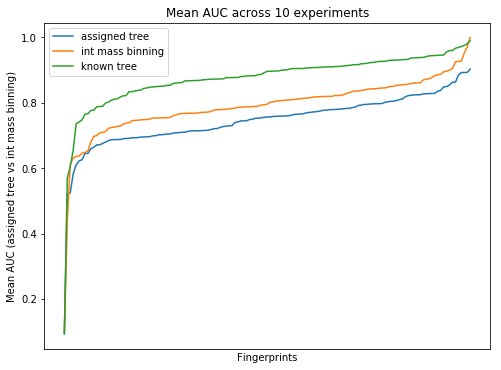

In [201]:
plt.title("Mean AUC across 10 experiments")
plt.plot(range(0, len(exp_mean_auc_scores)), exp_mean_auc_scores, label="assigned tree")
plt.plot(range(0, len(base_mean_auc_scores)), base_mean_auc_scores, label="int mass binning")
plt.plot(range(0, len(known_tree_mean_auc_scores)), known_tree_mean_auc_scores, label="known tree")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("Mean AUC (assigned tree vs int mass binning)")
plt.show()

AUC

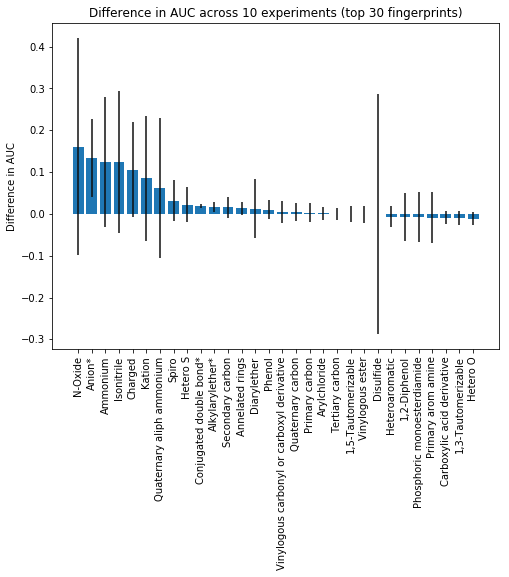

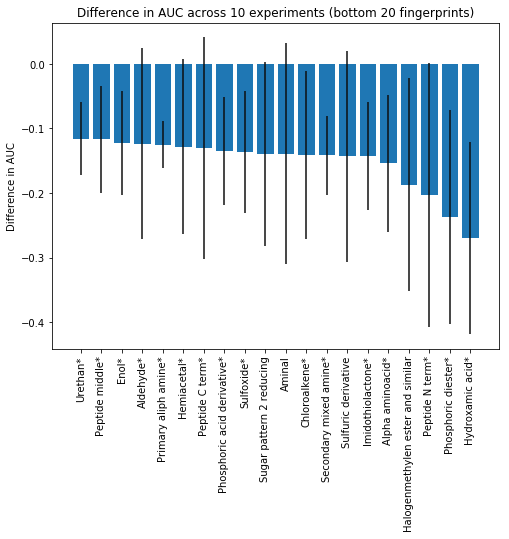

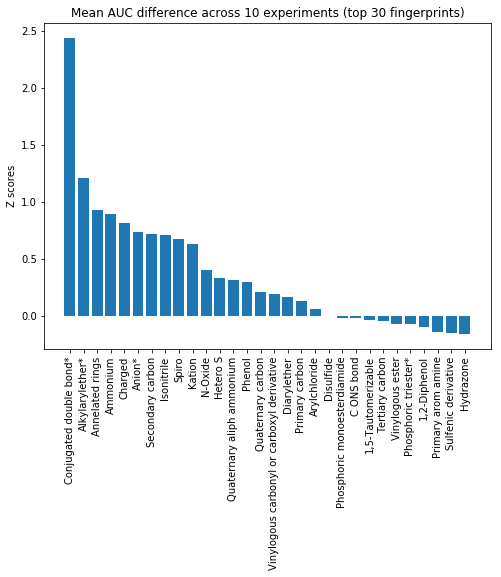

61 significantly different mean aucs
3 significantly positive difference
58 significantly negative difference


In [202]:
error_config = {'ecolor': '0.05'}

plt.title("Difference in AUC across 10 experiments (top 30 fingerprints)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Difference in AUC across 10 experiments (bottom 20 fingerprints)")
plt.bar(fingerprints[119:], score_differences[119:], align='center', yerr=std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Mean AUC difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

In [203]:
f1_differences = []
f1_z_differences = []
f1_pvalues = []

for i in assigned_tree_auc_df.columns:
    base_f1s = fragments_with_shifts_f1_df[i].tolist()
    base_mean = statistics.mean(base_f1s)
    base_std = statistics.stdev(base_f1s)
    
    exp_f1s = assigned_tree_f1_df[i].tolist()
    exp_mean = statistics.mean(exp_f1s)
    exp_std = statistics.stdev(exp_f1s)
    
    difference = [exp_f1-base_f1s[index] for index, exp_f1 in enumerate(exp_f1s) if exp_f1-base_f1s[index] != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    f1_pvalues.append((i, t_test.pvalue))

In [204]:
f1_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

f1_differences.reverse()
f1_z_differences.reverse()

In [205]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [206]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]

f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

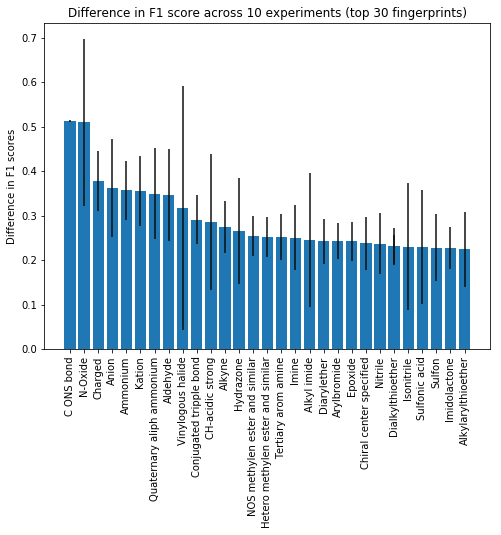

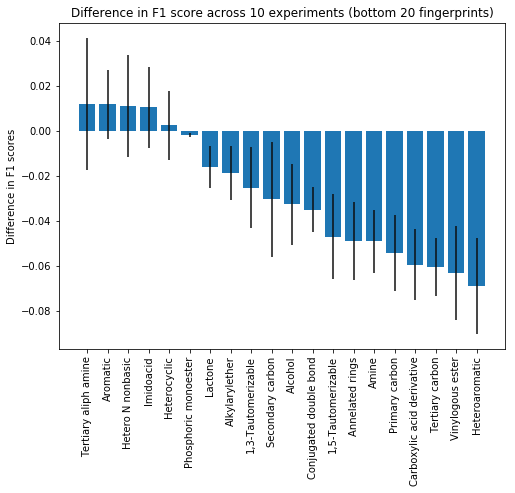

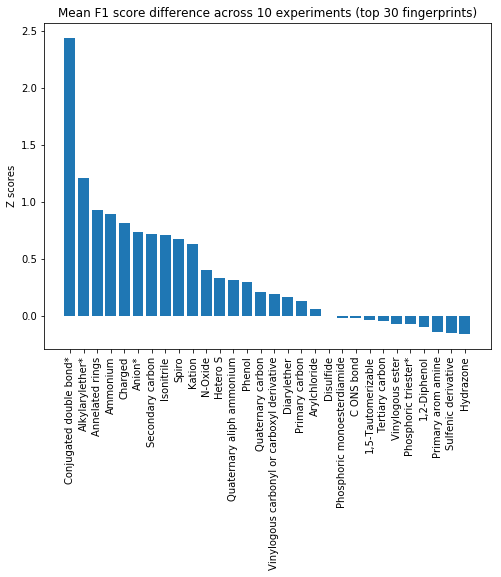

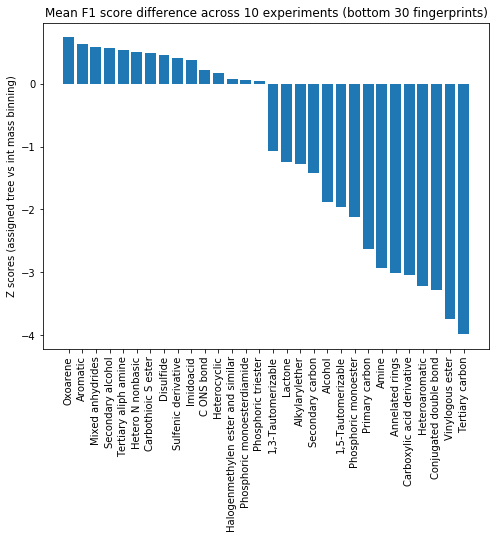

0 significantly different mean f1 scores
0 significantly positive difference
0 significantly negative difference


In [207]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (top 30 fingerprints)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Difference in F1 score across 10 experiments (bottom 20 fingerprints)")
plt.bar(f1_fingerprints[119:], f1_score_differences[119:], align='center', yerr=f1_std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Mean F1 score difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean F1 score difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(f1_z_fingerprints[109:], f1_z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores (assigned tree vs int mass binning)")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1 scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

Assign according to its known ionization

Load files and get its ionization

In [181]:
file_ionization = {}

for file in os.listdir(gnps_dir):
    filepath = os.path.join(gnps_dir, file)
    with open(filepath, 'r') as f:
        content = f.readlines()
        ionization_line = content[3]
        ionization = 'H'
        for ion in ion_mass.keys():
            if ion in ionization_line:
                ionization = ion
            
        file_ionization[file[:-3]] = ionization

Count how many missed ionization from assigning

In [183]:
missed_count = 0

for file in os.listdir(gnps_dir):
    print(file)
    filepath = os.path.join(gnps_dir, file)
    with open(filepath, 'r') as f:
        ionization_entries_count = []
        unsplit_lines = list(islice(f, 9, None))
        mass_intensity_list = convert_lines_to_list(unsplit_lines)
        for ion in ion_mass.keys():
            ionization_entries_count.append((ion, count_intensities_in_vector(mass_intensity_list, ion_mass[ion])))
        ion_with_most_entries = max(ionization_entries_count, key=lambda x:x[1])[0]
        if ion_with_most_entries != file_ionization[file[:-3]]:
            missed_count += 1
            
print("Missed ionization: {}".format(missed_count))

CCMSLIB00000001548.ms
CCMSLIB00000001549.ms
CCMSLIB00000001550.ms
CCMSLIB00000001555.ms
CCMSLIB00000001563.ms
CCMSLIB00000001565.ms
CCMSLIB00000001566.ms
CCMSLIB00000001568.ms
CCMSLIB00000001569.ms
CCMSLIB00000001570.ms
CCMSLIB00000001572.ms
CCMSLIB00000001574.ms
CCMSLIB00000001576.ms
CCMSLIB00000001581.ms
CCMSLIB00000001590.ms
CCMSLIB00000001598.ms
CCMSLIB00000001600.ms
CCMSLIB00000001601.ms
CCMSLIB00000001602.ms
CCMSLIB00000001603.ms
CCMSLIB00000001604.ms
CCMSLIB00000001606.ms
CCMSLIB00000001607.ms
CCMSLIB00000001608.ms
CCMSLIB00000001609.ms
CCMSLIB00000001615.ms
CCMSLIB00000001616.ms
CCMSLIB00000001617.ms
CCMSLIB00000001621.ms
CCMSLIB00000001622.ms
CCMSLIB00000001623.ms
CCMSLIB00000001624.ms
CCMSLIB00000001625.ms
CCMSLIB00000001631.ms
CCMSLIB00000001633.ms
CCMSLIB00000001634.ms
CCMSLIB00000001635.ms
CCMSLIB00000001637.ms
CCMSLIB00000001638.ms
CCMSLIB00000001641.ms
CCMSLIB00000001642.ms
CCMSLIB00000001643.ms
CCMSLIB00000001645.ms
CCMSLIB00000001646.ms
CCMSLIB00000001650.ms
CCMSLIB000

CCMSLIB00000006142.ms
CCMSLIB00000006145.ms
CCMSLIB00000006148.ms
CCMSLIB00000006154.ms
CCMSLIB00000006157.ms
CCMSLIB00000006160.ms
CCMSLIB00000006166.ms
CCMSLIB00000006169.ms
CCMSLIB00000006178.ms
CCMSLIB00000006181.ms
CCMSLIB00000006184.ms
CCMSLIB00000006187.ms
CCMSLIB00000006190.ms
CCMSLIB00000006202.ms
CCMSLIB00000006205.ms
CCMSLIB00000006208.ms
CCMSLIB00000006211.ms
CCMSLIB00000006214.ms
CCMSLIB00000006217.ms
CCMSLIB00000006232.ms
CCMSLIB00000006238.ms
CCMSLIB00000006244.ms
CCMSLIB00000006256.ms
CCMSLIB00000006259.ms
CCMSLIB00000006262.ms
CCMSLIB00000006265.ms
CCMSLIB00000006268.ms
CCMSLIB00000006271.ms
CCMSLIB00000006277.ms
CCMSLIB00000006280.ms
CCMSLIB00000006289.ms
CCMSLIB00000006292.ms
CCMSLIB00000006295.ms
CCMSLIB00000006301.ms
CCMSLIB00000006304.ms
CCMSLIB00000006307.ms
CCMSLIB00000006310.ms
CCMSLIB00000006313.ms
CCMSLIB00000006316.ms
CCMSLIB00000006331.ms
CCMSLIB00000006337.ms
CCMSLIB00000006340.ms
CCMSLIB00000006355.ms
CCMSLIB00000006364.ms
CCMSLIB00000006367.ms
CCMSLIB000

CCMSLIB00000077106.ms
CCMSLIB00000077107.ms
CCMSLIB00000077108.ms
CCMSLIB00000077111.ms
CCMSLIB00000077112.ms
CCMSLIB00000077113.ms
CCMSLIB00000077114.ms
CCMSLIB00000077115.ms
CCMSLIB00000077117.ms
CCMSLIB00000077118.ms
CCMSLIB00000077121.ms
CCMSLIB00000077123.ms
CCMSLIB00000077124.ms
CCMSLIB00000077125.ms
CCMSLIB00000077126.ms
CCMSLIB00000077129.ms
CCMSLIB00000077130.ms
CCMSLIB00000077131.ms
CCMSLIB00000077132.ms
CCMSLIB00000077134.ms
CCMSLIB00000077135.ms
CCMSLIB00000077136.ms
CCMSLIB00000077137.ms
CCMSLIB00000077138.ms
CCMSLIB00000077145.ms
CCMSLIB00000077147.ms
CCMSLIB00000077149.ms
CCMSLIB00000077150.ms
CCMSLIB00000077153.ms
CCMSLIB00000077192.ms
CCMSLIB00000077194.ms
CCMSLIB00000077195.ms
CCMSLIB00000077196.ms
CCMSLIB00000077197.ms
CCMSLIB00000077198.ms
CCMSLIB00000077199.ms
CCMSLIB00000077200.ms
CCMSLIB00000077201.ms
CCMSLIB00000077202.ms
CCMSLIB00000077203.ms
CCMSLIB00000077204.ms
CCMSLIB00000077205.ms
CCMSLIB00000077206.ms
CCMSLIB00000077207.ms
CCMSLIB00000077208.ms
CCMSLIB000

CCMSLIB00000078373.ms
CCMSLIB00000078374.ms
CCMSLIB00000078375.ms
CCMSLIB00000078377.ms
CCMSLIB00000078378.ms
CCMSLIB00000078379.ms
CCMSLIB00000078381.ms
CCMSLIB00000078383.ms
CCMSLIB00000078384.ms
CCMSLIB00000078385.ms
CCMSLIB00000078386.ms
CCMSLIB00000078387.ms
CCMSLIB00000078388.ms
CCMSLIB00000078390.ms
CCMSLIB00000078391.ms
CCMSLIB00000078392.ms
CCMSLIB00000078393.ms
CCMSLIB00000078395.ms
CCMSLIB00000078397.ms
CCMSLIB00000078398.ms
CCMSLIB00000078399.ms
CCMSLIB00000078400.ms
CCMSLIB00000078401.ms
CCMSLIB00000078402.ms
CCMSLIB00000078403.ms
CCMSLIB00000078404.ms
CCMSLIB00000078405.ms
CCMSLIB00000078406.ms
CCMSLIB00000078407.ms
CCMSLIB00000078408.ms
CCMSLIB00000078410.ms
CCMSLIB00000078411.ms
CCMSLIB00000078412.ms
CCMSLIB00000078413.ms
CCMSLIB00000078414.ms
CCMSLIB00000078416.ms
CCMSLIB00000078417.ms
CCMSLIB00000078418.ms
CCMSLIB00000078419.ms
CCMSLIB00000078420.ms
CCMSLIB00000078422.ms
CCMSLIB00000078423.ms
CCMSLIB00000078424.ms
CCMSLIB00000078425.ms
CCMSLIB00000078426.ms
CCMSLIB000

CCMSLIB00000078822.ms
CCMSLIB00000078845.ms
CCMSLIB00000078850.ms
CCMSLIB00000078851.ms
CCMSLIB00000078852.ms
CCMSLIB00000078855.ms
CCMSLIB00000078856.ms
CCMSLIB00000078857.ms
CCMSLIB00000078858.ms
CCMSLIB00000078859.ms
CCMSLIB00000078861.ms
CCMSLIB00000078862.ms
CCMSLIB00000078866.ms
CCMSLIB00000078867.ms
CCMSLIB00000078868.ms
CCMSLIB00000078869.ms
CCMSLIB00000078872.ms
CCMSLIB00000078877.ms
CCMSLIB00000078882.ms
CCMSLIB00000078899.ms
CCMSLIB00000078900.ms
CCMSLIB00000078901.ms
CCMSLIB00000078902.ms
CCMSLIB00000078904.ms
CCMSLIB00000078905.ms
CCMSLIB00000078906.ms
CCMSLIB00000078907.ms
CCMSLIB00000078908.ms
CCMSLIB00000078910.ms
CCMSLIB00000078911.ms
CCMSLIB00000078912.ms
CCMSLIB00000078913.ms
CCMSLIB00000078914.ms
CCMSLIB00000078915.ms
CCMSLIB00000078916.ms
CCMSLIB00000078917.ms
CCMSLIB00000078918.ms
CCMSLIB00000078919.ms
CCMSLIB00000078920.ms
CCMSLIB00000078921.ms
CCMSLIB00000078922.ms
CCMSLIB00000078923.ms
CCMSLIB00000078925.ms
CCMSLIB00000078928.ms
CCMSLIB00000078929.ms
CCMSLIB000

CCMSLIB00000079381.ms
CCMSLIB00000079382.ms
CCMSLIB00000079383.ms
CCMSLIB00000079384.ms
CCMSLIB00000079385.ms
CCMSLIB00000079386.ms
CCMSLIB00000079387.ms
CCMSLIB00000079388.ms
CCMSLIB00000079389.ms
CCMSLIB00000079390.ms
CCMSLIB00000079391.ms
CCMSLIB00000079392.ms
CCMSLIB00000079393.ms
CCMSLIB00000079394.ms
CCMSLIB00000079395.ms
CCMSLIB00000079396.ms
CCMSLIB00000079397.ms
CCMSLIB00000079398.ms
CCMSLIB00000079399.ms
CCMSLIB00000079401.ms
CCMSLIB00000079402.ms
CCMSLIB00000079403.ms
CCMSLIB00000079404.ms
CCMSLIB00000079405.ms
CCMSLIB00000079406.ms
CCMSLIB00000079407.ms
CCMSLIB00000079408.ms
CCMSLIB00000079409.ms
CCMSLIB00000079410.ms
CCMSLIB00000079411.ms
CCMSLIB00000079412.ms
CCMSLIB00000079413.ms
CCMSLIB00000079414.ms
CCMSLIB00000079415.ms
CCMSLIB00000079416.ms
CCMSLIB00000079417.ms
CCMSLIB00000079418.ms
CCMSLIB00000079419.ms
CCMSLIB00000079420.ms
CCMSLIB00000079421.ms
CCMSLIB00000079422.ms
CCMSLIB00000079423.ms
CCMSLIB00000079424.ms
CCMSLIB00000079425.ms
CCMSLIB00000079427.ms
CCMSLIB000

CCMSLIB00000079769.ms
CCMSLIB00000079770.ms
CCMSLIB00000079771.ms
CCMSLIB00000079772.ms
CCMSLIB00000079773.ms
CCMSLIB00000079774.ms
CCMSLIB00000079775.ms
CCMSLIB00000079776.ms
CCMSLIB00000079777.ms
CCMSLIB00000079778.ms
CCMSLIB00000079779.ms
CCMSLIB00000079780.ms
CCMSLIB00000079781.ms
CCMSLIB00000079782.ms
CCMSLIB00000079783.ms
CCMSLIB00000079784.ms
CCMSLIB00000079785.ms
CCMSLIB00000079786.ms
CCMSLIB00000079787.ms
CCMSLIB00000079788.ms
CCMSLIB00000079789.ms
CCMSLIB00000079790.ms
CCMSLIB00000079791.ms
CCMSLIB00000079792.ms
CCMSLIB00000079793.ms
CCMSLIB00000079795.ms
CCMSLIB00000079796.ms
CCMSLIB00000079797.ms
CCMSLIB00000079798.ms
CCMSLIB00000079800.ms
CCMSLIB00000079801.ms
CCMSLIB00000079802.ms
CCMSLIB00000079803.ms
CCMSLIB00000079804.ms
CCMSLIB00000079805.ms
CCMSLIB00000079806.ms
CCMSLIB00000079807.ms
CCMSLIB00000079808.ms
CCMSLIB00000079809.ms
CCMSLIB00000079810.ms
CCMSLIB00000079811.ms
CCMSLIB00000079812.ms
CCMSLIB00000079813.ms
CCMSLIB00000079814.ms
CCMSLIB00000079815.ms
CCMSLIB000

CCMSLIB00000080161.ms
CCMSLIB00000080162.ms
CCMSLIB00000080163.ms
CCMSLIB00000080164.ms
CCMSLIB00000080165.ms
CCMSLIB00000080166.ms
CCMSLIB00000080167.ms
CCMSLIB00000080168.ms
CCMSLIB00000080169.ms
CCMSLIB00000080170.ms
CCMSLIB00000080171.ms
CCMSLIB00000080173.ms
CCMSLIB00000080174.ms
CCMSLIB00000080175.ms
CCMSLIB00000080176.ms
CCMSLIB00000080177.ms
CCMSLIB00000080178.ms
CCMSLIB00000080179.ms
CCMSLIB00000080180.ms
CCMSLIB00000080181.ms
CCMSLIB00000080182.ms
CCMSLIB00000080183.ms
CCMSLIB00000080184.ms
CCMSLIB00000080185.ms
CCMSLIB00000080186.ms
CCMSLIB00000080187.ms
CCMSLIB00000080188.ms
CCMSLIB00000080189.ms
CCMSLIB00000080190.ms
CCMSLIB00000080191.ms
CCMSLIB00000080193.ms
CCMSLIB00000080194.ms
CCMSLIB00000080195.ms
CCMSLIB00000080196.ms
CCMSLIB00000080197.ms
CCMSLIB00000080198.ms
CCMSLIB00000080199.ms
CCMSLIB00000080200.ms
CCMSLIB00000080201.ms
CCMSLIB00000080202.ms
CCMSLIB00000080203.ms
CCMSLIB00000080204.ms
CCMSLIB00000080205.ms
CCMSLIB00000080206.ms
CCMSLIB00000080207.ms
CCMSLIB000

CCMSLIB00000080544.ms
CCMSLIB00000080545.ms
CCMSLIB00000080546.ms
CCMSLIB00000080547.ms
CCMSLIB00000080548.ms
CCMSLIB00000080549.ms
CCMSLIB00000080550.ms
CCMSLIB00000080551.ms
CCMSLIB00000080552.ms
CCMSLIB00000080553.ms
CCMSLIB00000080554.ms
CCMSLIB00000080555.ms
CCMSLIB00000080556.ms
CCMSLIB00000080557.ms
CCMSLIB00000080558.ms
CCMSLIB00000080559.ms
CCMSLIB00000080560.ms
CCMSLIB00000080561.ms
CCMSLIB00000080562.ms
CCMSLIB00000080563.ms
CCMSLIB00000080564.ms
CCMSLIB00000080565.ms
CCMSLIB00000080566.ms
CCMSLIB00000080567.ms
CCMSLIB00000080568.ms
CCMSLIB00000080569.ms
CCMSLIB00000080570.ms
CCMSLIB00000080571.ms
CCMSLIB00000080572.ms
CCMSLIB00000080573.ms
CCMSLIB00000080574.ms
CCMSLIB00000080575.ms
CCMSLIB00000080576.ms
CCMSLIB00000080577.ms
CCMSLIB00000080578.ms
CCMSLIB00000080579.ms
CCMSLIB00000080580.ms
CCMSLIB00000080581.ms
CCMSLIB00000080582.ms
CCMSLIB00000080583.ms
CCMSLIB00000080584.ms
CCMSLIB00000080585.ms
CCMSLIB00000080586.ms
CCMSLIB00000080587.ms
CCMSLIB00000080588.ms
CCMSLIB000

CCMSLIB00000084915.ms
CCMSLIB00000084916.ms
CCMSLIB00000084917.ms
CCMSLIB00000084918.ms
CCMSLIB00000084919.ms
CCMSLIB00000084920.ms
CCMSLIB00000084921.ms
CCMSLIB00000084922.ms
CCMSLIB00000084923.ms
CCMSLIB00000084924.ms
CCMSLIB00000084926.ms
CCMSLIB00000084927.ms
CCMSLIB00000084928.ms
CCMSLIB00000084929.ms
CCMSLIB00000084931.ms
CCMSLIB00000084932.ms
CCMSLIB00000084933.ms
CCMSLIB00000084934.ms
CCMSLIB00000084935.ms
CCMSLIB00000084936.ms
CCMSLIB00000084937.ms
CCMSLIB00000084938.ms
CCMSLIB00000084939.ms
CCMSLIB00000084940.ms
CCMSLIB00000084942.ms
CCMSLIB00000084943.ms
CCMSLIB00000084944.ms
CCMSLIB00000084946.ms
CCMSLIB00000084947.ms
CCMSLIB00000084948.ms
CCMSLIB00000084949.ms
CCMSLIB00000084950.ms
CCMSLIB00000084951.ms
CCMSLIB00000084952.ms
CCMSLIB00000084953.ms
CCMSLIB00000084954.ms
CCMSLIB00000084955.ms
CCMSLIB00000084956.ms
CCMSLIB00000084958.ms
CCMSLIB00000084959.ms
CCMSLIB00000084960.ms
CCMSLIB00000084961.ms
CCMSLIB00000084962.ms
CCMSLIB00000084963.ms
CCMSLIB00000084964.ms
CCMSLIB000

CCMSLIB00000085361.ms
CCMSLIB00000085362.ms
CCMSLIB00000085363.ms
CCMSLIB00000085364.ms
CCMSLIB00000085365.ms
CCMSLIB00000085366.ms
CCMSLIB00000085367.ms
CCMSLIB00000085368.ms
CCMSLIB00000085369.ms
CCMSLIB00000085370.ms
CCMSLIB00000085371.ms
CCMSLIB00000085372.ms
CCMSLIB00000085373.ms
CCMSLIB00000085374.ms
CCMSLIB00000085375.ms
CCMSLIB00000085376.ms
CCMSLIB00000085377.ms
CCMSLIB00000085378.ms
CCMSLIB00000085379.ms
CCMSLIB00000085380.ms
CCMSLIB00000085381.ms
CCMSLIB00000085382.ms
CCMSLIB00000085383.ms
CCMSLIB00000085385.ms
CCMSLIB00000085386.ms
CCMSLIB00000085387.ms
CCMSLIB00000085388.ms
CCMSLIB00000085389.ms
CCMSLIB00000085390.ms
CCMSLIB00000085391.ms
CCMSLIB00000085392.ms
CCMSLIB00000085393.ms
CCMSLIB00000085394.ms
CCMSLIB00000085395.ms
CCMSLIB00000085396.ms
CCMSLIB00000085397.ms
CCMSLIB00000085398.ms
CCMSLIB00000085399.ms
CCMSLIB00000085400.ms
CCMSLIB00000085401.ms
CCMSLIB00000085402.ms
CCMSLIB00000085403.ms
CCMSLIB00000085404.ms
CCMSLIB00000085405.ms
CCMSLIB00000085406.ms
CCMSLIB000

CCMSLIB00000085765.ms
CCMSLIB00000085766.ms
CCMSLIB00000085767.ms
CCMSLIB00000085768.ms
CCMSLIB00000085770.ms
CCMSLIB00000085771.ms
CCMSLIB00000085772.ms
CCMSLIB00000085774.ms
CCMSLIB00000085775.ms
CCMSLIB00000085776.ms
CCMSLIB00000085777.ms
CCMSLIB00000085778.ms
CCMSLIB00000085779.ms
CCMSLIB00000085780.ms
CCMSLIB00000085781.ms
CCMSLIB00000085783.ms
CCMSLIB00000085784.ms
CCMSLIB00000085785.ms
CCMSLIB00000085786.ms
CCMSLIB00000085787.ms
CCMSLIB00000085789.ms
CCMSLIB00000085790.ms
CCMSLIB00000085792.ms
CCMSLIB00000085793.ms
CCMSLIB00000085794.ms
CCMSLIB00000085795.ms
CCMSLIB00000085796.ms
CCMSLIB00000085797.ms
CCMSLIB00000085798.ms
CCMSLIB00000085799.ms
CCMSLIB00000085800.ms
CCMSLIB00000085801.ms
CCMSLIB00000085802.ms
CCMSLIB00000085803.ms
CCMSLIB00000085804.ms
CCMSLIB00000085805.ms
CCMSLIB00000085806.ms
CCMSLIB00000085809.ms
CCMSLIB00000085810.ms
CCMSLIB00000085811.ms
CCMSLIB00000085812.ms
CCMSLIB00000085813.ms
CCMSLIB00000085814.ms
CCMSLIB00000085815.ms
CCMSLIB00000085816.ms
CCMSLIB000

CCMSLIB00000086174.ms
CCMSLIB00000086175.ms
CCMSLIB00000086176.ms
CCMSLIB00000086178.ms
CCMSLIB00000086179.ms
CCMSLIB00000086180.ms
CCMSLIB00000086181.ms
CCMSLIB00000086182.ms
CCMSLIB00000086183.ms
CCMSLIB00000086184.ms
CCMSLIB00000086185.ms
CCMSLIB00000086186.ms
CCMSLIB00000086187.ms
CCMSLIB00000086188.ms
CCMSLIB00000086189.ms
CCMSLIB00000086190.ms
CCMSLIB00000086191.ms
CCMSLIB00000086192.ms
CCMSLIB00000086193.ms
CCMSLIB00000086194.ms
CCMSLIB00000086195.ms
CCMSLIB00000087826.ms
CCMSLIB00000204740.ms
CCMSLIB00000206187.ms
CCMSLIB00000223869.ms
CCMSLIB00000223870.ms
CCMSLIB00000223871.ms
CCMSLIB00000223873.ms
CCMSLIB00000223874.ms
CCMSLIB00000223876.ms
CCMSLIB00000223877.ms
CCMSLIB00000223878.ms
CCMSLIB00000223879.ms
CCMSLIB00000223880.ms
CCMSLIB00000223884.ms
CCMSLIB00000223885.ms
CCMSLIB00000223902.ms
CCMSLIB00000223953.ms
CCMSLIB00000223956.ms
CCMSLIB00000223957.ms
CCMSLIB00000223958.ms
CCMSLIB00000223959.ms
CCMSLIB00000223963.ms
CCMSLIB00000223993.ms
CCMSLIB00000223994.ms
CCMSLIB000

CCMSLIB00000478531.ms
CCMSLIB00000478532.ms
CCMSLIB00000478533.ms
CCMSLIB00000478536.ms
CCMSLIB00000478537.ms
CCMSLIB00000478539.ms
CCMSLIB00000478540.ms
CCMSLIB00000478541.ms
CCMSLIB00000478542.ms
CCMSLIB00000478543.ms
CCMSLIB00000478544.ms
CCMSLIB00000478545.ms
CCMSLIB00000478546.ms
CCMSLIB00000478548.ms
CCMSLIB00000478550.ms
CCMSLIB00000478551.ms
CCMSLIB00000478553.ms
CCMSLIB00000478555.ms
CCMSLIB00000478556.ms
CCMSLIB00000478558.ms
CCMSLIB00000478560.ms
CCMSLIB00000478579.ms
CCMSLIB00000478580.ms
CCMSLIB00000478581.ms
CCMSLIB00000478582.ms
CCMSLIB00000478583.ms
CCMSLIB00000478584.ms
CCMSLIB00000478585.ms
CCMSLIB00000478586.ms
CCMSLIB00000478587.ms
CCMSLIB00000478588.ms
CCMSLIB00000478589.ms
CCMSLIB00000478591.ms
CCMSLIB00000478592.ms
CCMSLIB00000478593.ms
CCMSLIB00000478595.ms
CCMSLIB00000478596.ms
CCMSLIB00000478598.ms
CCMSLIB00000478599.ms
CCMSLIB00000478600.ms
CCMSLIB00000478601.ms
CCMSLIB00000478602.ms
CCMSLIB00000478603.ms
CCMSLIB00000478608.ms
CCMSLIB00000478635.ms
CCMSLIB000

CCMSLIB00000579720.ms
CCMSLIB00000579721.ms
CCMSLIB00000579723.ms
CCMSLIB00000579724.ms
CCMSLIB00000579725.ms
CCMSLIB00000579726.ms
CCMSLIB00000579727.ms
CCMSLIB00000579728.ms
CCMSLIB00000579729.ms
CCMSLIB00000579730.ms
CCMSLIB00000579731.ms
CCMSLIB00000579732.ms
CCMSLIB00000579733.ms
CCMSLIB00000579734.ms
CCMSLIB00000579735.ms
CCMSLIB00000579736.ms
CCMSLIB00000579737.ms
CCMSLIB00000579738.ms
CCMSLIB00000579739.ms
CCMSLIB00000579740.ms
CCMSLIB00000579741.ms
CCMSLIB00000579742.ms
CCMSLIB00000579743.ms
CCMSLIB00000579744.ms
CCMSLIB00000579746.ms
CCMSLIB00000579747.ms
CCMSLIB00000579748.ms
CCMSLIB00000579749.ms
CCMSLIB00000579750.ms
CCMSLIB00000579751.ms
CCMSLIB00000579752.ms
CCMSLIB00000579753.ms
CCMSLIB00000579754.ms
CCMSLIB00000579755.ms
CCMSLIB00000579756.ms
CCMSLIB00000579757.ms
CCMSLIB00000579758.ms
CCMSLIB00000579759.ms
CCMSLIB00000579760.ms
CCMSLIB00000579761.ms
CCMSLIB00000579762.ms
CCMSLIB00000579763.ms
CCMSLIB00000579764.ms
CCMSLIB00000579765.ms
CCMSLIB00000579766.ms
CCMSLIB000

In [41]:
def assign_to_tree_with_known_ionization(gnps_dir):
    mol_ids = get_mol_names(gnps_dir)
    tree_intensities = pd.DataFrame(0.0, index=mol_ids, columns=combined_index, dtype=float)
        
    for file in os.listdir(gnps_dir):
        split_count = 0
        assigned_formula_intensity = []
        filepath = os.path.join(gnps_dir, file)
        with open(filepath, 'r') as f:
            ionization_entries_count = []
            unsplit_lines = list(islice(f, 9, None))
            mass_intensity_list = convert_lines_to_list(unsplit_lines)
            ionization = ion_mass[file_ionization[file[:-3]]]
            
            for mass, intensity in mass_intensity_list:
                non_ionized_mass = mass - ionization
                mass_int, decimals = str(non_ionized_mass).split(".")
                if int(mass_int) in fragment_mass_to_formula_dict:
                    chosen_bins = []
                    for full_mass, formula in fragment_mass_to_formula_dict[int(mass_int)].items():
                        if full_mass-0.025 <= non_ionized_mass <= full_mass+0.025: # within 0.05 width
                            chosen_bins.append(full_mass)
                    
                    if len(chosen_bins) > 1:
                        nearest_bin_allocation, furthest_bin_allocation = assign_between_bins(chosen_bins)
                        tree_intensities.at[file[:-3], fragment_mass_to_formula_dict[int(mass_int)][nearest_bin_allocation[0]]] += float(intensity) * nearest_bin_allocation[1]
                        tree_intensities.at[file[:-3], fragment_mass_to_formula_dict[int(mass_int)][furthest_bin_allocation[0]]] += float(intensity) * furthest_bin_allocation[1]
                        assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][nearest_bin_allocation[0]], 
                                                           nearest_bin_allocation[0], intensity*nearest_bin_allocation[1]))
                        assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][furthest_bin_allocation[0]], 
                                                           furthest_bin_allocation[0], intensity*furthest_bin_allocation[1]))
                        split_count += 1
                        
                    elif len(chosen_bins) == 1:
                        tree_intensities.at[file[:-3], fragment_mass_to_formula_dict[int(mass_int)][chosen_bins[0]]] += float(intensity)
                        assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][chosen_bins[0]], chosen_bins[0], intensity))
                    
                    else:
                        continue
            
            print(file, str(split_count))
            assigned_formula_intensity.sort(key = lambda t: t[1])
            assigned_formula_intensity.reverse() # highest to smallest

            peak_differences = [(subtract_formula(formula_intensity_i[0], formula_intensity_j[0]) + "_loss", 
                                 (formula_intensity_i[2] + formula_intensity_j[2]) / 2.0 ) 
                                for i, formula_intensity_i in enumerate(assigned_formula_intensity)
                                for j, formula_intensity_j in enumerate(assigned_formula_intensity) 
                                if i != j 
                                and j > i
                                and len(re.findall('[A-Z][a-z]*[0-9]*', formula_intensity_i[0])) >= len(re.findall('[A-Z][a-z]*[0-9]*', formula_intensity_j[0]))
                                and subtract_formula(formula_intensity_i[0], formula_intensity_j[0]) + "_loss" in losses_df.index]

            for formula, intensity in peak_differences:
                tree_intensities.at[file[:-3], formula] += float(intensity)
            
            if np.amax(tree_intensities.loc[file[:-3]]) > 0:
                tree_intensities.loc[file[:-3]] = tree_intensities.loc[file[:-3]].div(np.amax(tree_intensities.loc[file[:-3]].values)).mul(999)
                            
    return tree_intensities

In [20]:
assigned_tree_known_ionization_path = "G:\\Dev\\Data\\assigned_tree_final_known_ionization.pkl"

In [43]:
assigned_tree_with_known_ionization = assign_to_tree_with_known_ionization(gnps_dir)

CCMSLIB00000001548.ms 0
CCMSLIB00000001549.ms 0
CCMSLIB00000001550.ms 0
CCMSLIB00000001555.ms 0
CCMSLIB00000001563.ms 0
CCMSLIB00000001565.ms 0
CCMSLIB00000001566.ms 0
CCMSLIB00000001568.ms 0
CCMSLIB00000001569.ms 0
CCMSLIB00000001570.ms 0
CCMSLIB00000001572.ms 0
CCMSLIB00000001574.ms 0
CCMSLIB00000001576.ms 0
CCMSLIB00000001581.ms 0
CCMSLIB00000001590.ms 0
CCMSLIB00000001598.ms 0
CCMSLIB00000001600.ms 0
CCMSLIB00000001601.ms 0
CCMSLIB00000001602.ms 0
CCMSLIB00000001603.ms 0
CCMSLIB00000001604.ms 0
CCMSLIB00000001606.ms 0
CCMSLIB00000001607.ms 0
CCMSLIB00000001608.ms 0
CCMSLIB00000001609.ms 0
CCMSLIB00000001615.ms 0
CCMSLIB00000001616.ms 0
CCMSLIB00000001617.ms 0
CCMSLIB00000001621.ms 0
CCMSLIB00000001622.ms 0
CCMSLIB00000001623.ms 0
CCMSLIB00000001624.ms 0
CCMSLIB00000001625.ms 0
CCMSLIB00000001631.ms 0
CCMSLIB00000001633.ms 0
CCMSLIB00000001634.ms 0
CCMSLIB00000001635.ms 0
CCMSLIB00000001637.ms 0
CCMSLIB00000001638.ms 0
CCMSLIB00000001641.ms 0
CCMSLIB00000001642.ms 0
CCMSLIB000000016

CCMSLIB00000005792.ms 0
CCMSLIB00000005795.ms 0
CCMSLIB00000005798.ms 0
CCMSLIB00000005801.ms 0
CCMSLIB00000005804.ms 0
CCMSLIB00000005810.ms 0
CCMSLIB00000005825.ms 0
CCMSLIB00000005834.ms 0
CCMSLIB00000005843.ms 0
CCMSLIB00000005855.ms 0
CCMSLIB00000005858.ms 0
CCMSLIB00000005864.ms 0
CCMSLIB00000005873.ms 0
CCMSLIB00000005879.ms 0
CCMSLIB00000005882.ms 0
CCMSLIB00000005885.ms 0
CCMSLIB00000005888.ms 0
CCMSLIB00000005891.ms 0
CCMSLIB00000005897.ms 0
CCMSLIB00000005900.ms 0
CCMSLIB00000005903.ms 0
CCMSLIB00000005912.ms 0
CCMSLIB00000005915.ms 0
CCMSLIB00000005927.ms 0
CCMSLIB00000005935.ms 0
CCMSLIB00000005944.ms 0
CCMSLIB00000005961.ms 0
CCMSLIB00000005970.ms 0
CCMSLIB00000005973.ms 0
CCMSLIB00000005976.ms 0
CCMSLIB00000005982.ms 0
CCMSLIB00000005990.ms 0
CCMSLIB00000005993.ms 0
CCMSLIB00000005996.ms 0
CCMSLIB00000005999.ms 0
CCMSLIB00000006008.ms 0
CCMSLIB00000006011.ms 0
CCMSLIB00000006014.ms 0
CCMSLIB00000006017.ms 0
CCMSLIB00000006020.ms 0
CCMSLIB00000006029.ms 0
CCMSLIB000000060

CCMSLIB00000076749.ms 0
CCMSLIB00000076959.ms 0
CCMSLIB00000076960.ms 0
CCMSLIB00000076962.ms 0
CCMSLIB00000076963.ms 0
CCMSLIB00000076970.ms 0
CCMSLIB00000076972.ms 0
CCMSLIB00000076974.ms 0
CCMSLIB00000076975.ms 0
CCMSLIB00000076976.ms 0
CCMSLIB00000076977.ms 0
CCMSLIB00000076979.ms 0
CCMSLIB00000076980.ms 0
CCMSLIB00000076982.ms 0
CCMSLIB00000076983.ms 0
CCMSLIB00000076986.ms 0
CCMSLIB00000076987.ms 0
CCMSLIB00000076988.ms 0
CCMSLIB00000076991.ms 0
CCMSLIB00000076994.ms 0
CCMSLIB00000076996.ms 0
CCMSLIB00000076999.ms 0
CCMSLIB00000077003.ms 0
CCMSLIB00000077004.ms 0
CCMSLIB00000077005.ms 0
CCMSLIB00000077008.ms 0
CCMSLIB00000077009.ms 0
CCMSLIB00000077010.ms 0
CCMSLIB00000077011.ms 0
CCMSLIB00000077015.ms 0
CCMSLIB00000077016.ms 0
CCMSLIB00000077017.ms 0
CCMSLIB00000077018.ms 0
CCMSLIB00000077019.ms 0
CCMSLIB00000077020.ms 0
CCMSLIB00000077021.ms 0
CCMSLIB00000077022.ms 0
CCMSLIB00000077023.ms 0
CCMSLIB00000077024.ms 0
CCMSLIB00000077030.ms 0
CCMSLIB00000077032.ms 0
CCMSLIB000000770

CCMSLIB00000078235.ms 0
CCMSLIB00000078236.ms 0
CCMSLIB00000078237.ms 0
CCMSLIB00000078238.ms 0
CCMSLIB00000078239.ms 0
CCMSLIB00000078240.ms 0
CCMSLIB00000078241.ms 0
CCMSLIB00000078242.ms 0
CCMSLIB00000078243.ms 0
CCMSLIB00000078244.ms 0
CCMSLIB00000078245.ms 0
CCMSLIB00000078246.ms 0
CCMSLIB00000078247.ms 0
CCMSLIB00000078248.ms 0
CCMSLIB00000078249.ms 0
CCMSLIB00000078250.ms 0
CCMSLIB00000078251.ms 0
CCMSLIB00000078252.ms 0
CCMSLIB00000078253.ms 0
CCMSLIB00000078254.ms 0
CCMSLIB00000078255.ms 0
CCMSLIB00000078256.ms 0
CCMSLIB00000078257.ms 0
CCMSLIB00000078259.ms 0
CCMSLIB00000078260.ms 0
CCMSLIB00000078261.ms 0
CCMSLIB00000078262.ms 0
CCMSLIB00000078263.ms 0
CCMSLIB00000078264.ms 0
CCMSLIB00000078265.ms 0
CCMSLIB00000078266.ms 0
CCMSLIB00000078268.ms 0
CCMSLIB00000078269.ms 0
CCMSLIB00000078270.ms 0
CCMSLIB00000078271.ms 0
CCMSLIB00000078272.ms 0
CCMSLIB00000078273.ms 0
CCMSLIB00000078274.ms 0
CCMSLIB00000078275.ms 0
CCMSLIB00000078276.ms 0
CCMSLIB00000078277.ms 0
CCMSLIB000000782

CCMSLIB00000078642.ms 0
CCMSLIB00000078643.ms 0
CCMSLIB00000078644.ms 0
CCMSLIB00000078645.ms 0
CCMSLIB00000078646.ms 0
CCMSLIB00000078647.ms 0
CCMSLIB00000078648.ms 0
CCMSLIB00000078650.ms 0
CCMSLIB00000078651.ms 0
CCMSLIB00000078652.ms 0
CCMSLIB00000078653.ms 0
CCMSLIB00000078668.ms 0
CCMSLIB00000078679.ms 0
CCMSLIB00000078680.ms 0
CCMSLIB00000078681.ms 0
CCMSLIB00000078683.ms 0
CCMSLIB00000078684.ms 0
CCMSLIB00000078685.ms 0
CCMSLIB00000078686.ms 0
CCMSLIB00000078687.ms 0
CCMSLIB00000078688.ms 0
CCMSLIB00000078689.ms 0
CCMSLIB00000078690.ms 0
CCMSLIB00000078691.ms 0
CCMSLIB00000078692.ms 0
CCMSLIB00000078693.ms 0
CCMSLIB00000078694.ms 0
CCMSLIB00000078695.ms 0
CCMSLIB00000078696.ms 0
CCMSLIB00000078697.ms 0
CCMSLIB00000078698.ms 0
CCMSLIB00000078699.ms 0
CCMSLIB00000078700.ms 0
CCMSLIB00000078701.ms 0
CCMSLIB00000078702.ms 0
CCMSLIB00000078703.ms 0
CCMSLIB00000078704.ms 0
CCMSLIB00000078705.ms 0
CCMSLIB00000078706.ms 0
CCMSLIB00000078707.ms 0
CCMSLIB00000078708.ms 0
CCMSLIB000000787

CCMSLIB00000079096.ms 0
CCMSLIB00000079098.ms 0
CCMSLIB00000079099.ms 0
CCMSLIB00000079100.ms 0
CCMSLIB00000079101.ms 0
CCMSLIB00000079102.ms 0
CCMSLIB00000079104.ms 0
CCMSLIB00000079105.ms 0
CCMSLIB00000079106.ms 0
CCMSLIB00000079107.ms 0
CCMSLIB00000079108.ms 0
CCMSLIB00000079110.ms 0
CCMSLIB00000079111.ms 0
CCMSLIB00000079112.ms 0
CCMSLIB00000079113.ms 0
CCMSLIB00000079114.ms 0
CCMSLIB00000079115.ms 0
CCMSLIB00000079116.ms 0
CCMSLIB00000079117.ms 0
CCMSLIB00000079118.ms 0
CCMSLIB00000079119.ms 0
CCMSLIB00000079120.ms 0
CCMSLIB00000079121.ms 0
CCMSLIB00000079122.ms 0
CCMSLIB00000079123.ms 0
CCMSLIB00000079124.ms 0
CCMSLIB00000079125.ms 0
CCMSLIB00000079126.ms 0
CCMSLIB00000079127.ms 0
CCMSLIB00000079128.ms 0
CCMSLIB00000079129.ms 0
CCMSLIB00000079130.ms 0
CCMSLIB00000079131.ms 0
CCMSLIB00000079132.ms 0
CCMSLIB00000079134.ms 0
CCMSLIB00000079135.ms 0
CCMSLIB00000079136.ms 0
CCMSLIB00000079137.ms 0
CCMSLIB00000079138.ms 0
CCMSLIB00000079139.ms 0
CCMSLIB00000079140.ms 0
CCMSLIB000000791

CCMSLIB00000079540.ms 0
CCMSLIB00000079541.ms 0
CCMSLIB00000079542.ms 0
CCMSLIB00000079543.ms 0
CCMSLIB00000079544.ms 0
CCMSLIB00000079545.ms 0
CCMSLIB00000079546.ms 0
CCMSLIB00000079547.ms 0
CCMSLIB00000079548.ms 0
CCMSLIB00000079549.ms 0
CCMSLIB00000079550.ms 0
CCMSLIB00000079551.ms 0
CCMSLIB00000079552.ms 0
CCMSLIB00000079553.ms 0
CCMSLIB00000079554.ms 0
CCMSLIB00000079555.ms 0
CCMSLIB00000079556.ms 0
CCMSLIB00000079557.ms 0
CCMSLIB00000079558.ms 0
CCMSLIB00000079559.ms 0
CCMSLIB00000079560.ms 0
CCMSLIB00000079561.ms 0
CCMSLIB00000079562.ms 0
CCMSLIB00000079563.ms 0
CCMSLIB00000079564.ms 0
CCMSLIB00000079565.ms 0
CCMSLIB00000079566.ms 0
CCMSLIB00000079567.ms 0
CCMSLIB00000079568.ms 0
CCMSLIB00000079569.ms 0
CCMSLIB00000079570.ms 0
CCMSLIB00000079571.ms 0
CCMSLIB00000079572.ms 0
CCMSLIB00000079573.ms 0
CCMSLIB00000079574.ms 0
CCMSLIB00000079575.ms 0
CCMSLIB00000079576.ms 0
CCMSLIB00000079577.ms 0
CCMSLIB00000079578.ms 0
CCMSLIB00000079579.ms 0
CCMSLIB00000079580.ms 0
CCMSLIB000000795

CCMSLIB00000079891.ms 0
CCMSLIB00000079892.ms 0
CCMSLIB00000079893.ms 0
CCMSLIB00000079894.ms 0
CCMSLIB00000079895.ms 0
CCMSLIB00000079896.ms 0
CCMSLIB00000079897.ms 0
CCMSLIB00000079898.ms 0
CCMSLIB00000079899.ms 0
CCMSLIB00000079900.ms 0
CCMSLIB00000079901.ms 0
CCMSLIB00000079902.ms 0
CCMSLIB00000079903.ms 0
CCMSLIB00000079904.ms 0
CCMSLIB00000079905.ms 0
CCMSLIB00000079906.ms 0
CCMSLIB00000079907.ms 0
CCMSLIB00000079908.ms 0
CCMSLIB00000079909.ms 0
CCMSLIB00000079910.ms 0
CCMSLIB00000079911.ms 0
CCMSLIB00000079912.ms 0
CCMSLIB00000079913.ms 0
CCMSLIB00000079914.ms 0
CCMSLIB00000079915.ms 0
CCMSLIB00000079916.ms 0
CCMSLIB00000079917.ms 0
CCMSLIB00000079918.ms 0
CCMSLIB00000079919.ms 0
CCMSLIB00000079920.ms 0
CCMSLIB00000079921.ms 0
CCMSLIB00000079922.ms 0
CCMSLIB00000079923.ms 0
CCMSLIB00000079925.ms 0
CCMSLIB00000079926.ms 0
CCMSLIB00000079927.ms 0
CCMSLIB00000079928.ms 0
CCMSLIB00000079929.ms 0
CCMSLIB00000079930.ms 0
CCMSLIB00000079931.ms 0
CCMSLIB00000079932.ms 0
CCMSLIB000000799

CCMSLIB00000080238.ms 0
CCMSLIB00000080239.ms 0
CCMSLIB00000080240.ms 0
CCMSLIB00000080242.ms 0
CCMSLIB00000080243.ms 0
CCMSLIB00000080244.ms 0
CCMSLIB00000080245.ms 0
CCMSLIB00000080246.ms 0
CCMSLIB00000080247.ms 0
CCMSLIB00000080248.ms 0
CCMSLIB00000080249.ms 0
CCMSLIB00000080250.ms 0
CCMSLIB00000080251.ms 0
CCMSLIB00000080252.ms 0
CCMSLIB00000080253.ms 0
CCMSLIB00000080254.ms 0
CCMSLIB00000080255.ms 0
CCMSLIB00000080256.ms 0
CCMSLIB00000080257.ms 0
CCMSLIB00000080258.ms 0
CCMSLIB00000080259.ms 0
CCMSLIB00000080260.ms 0
CCMSLIB00000080261.ms 0
CCMSLIB00000080262.ms 0
CCMSLIB00000080263.ms 0
CCMSLIB00000080264.ms 0
CCMSLIB00000080265.ms 0
CCMSLIB00000080266.ms 0
CCMSLIB00000080267.ms 0
CCMSLIB00000080268.ms 0
CCMSLIB00000080269.ms 0
CCMSLIB00000080270.ms 0
CCMSLIB00000080271.ms 0
CCMSLIB00000080272.ms 0
CCMSLIB00000080273.ms 0
CCMSLIB00000080274.ms 0
CCMSLIB00000080275.ms 0
CCMSLIB00000080276.ms 0
CCMSLIB00000080277.ms 0
CCMSLIB00000080278.ms 0
CCMSLIB00000080279.ms 0
CCMSLIB000000802

CCMSLIB00000080585.ms 0
CCMSLIB00000080586.ms 0
CCMSLIB00000080587.ms 0
CCMSLIB00000080588.ms 0
CCMSLIB00000080589.ms 0
CCMSLIB00000080590.ms 0
CCMSLIB00000080591.ms 0
CCMSLIB00000080592.ms 0
CCMSLIB00000080593.ms 0
CCMSLIB00000080594.ms 0
CCMSLIB00000080595.ms 0
CCMSLIB00000080596.ms 0
CCMSLIB00000080597.ms 0
CCMSLIB00000080598.ms 0
CCMSLIB00000080599.ms 0
CCMSLIB00000080600.ms 0
CCMSLIB00000080602.ms 0
CCMSLIB00000080603.ms 0
CCMSLIB00000080604.ms 0
CCMSLIB00000080605.ms 0
CCMSLIB00000080606.ms 0
CCMSLIB00000080607.ms 0
CCMSLIB00000080608.ms 0
CCMSLIB00000080609.ms 0
CCMSLIB00000080610.ms 0
CCMSLIB00000080611.ms 0
CCMSLIB00000080612.ms 0
CCMSLIB00000080613.ms 0
CCMSLIB00000080614.ms 0
CCMSLIB00000080615.ms 0
CCMSLIB00000080616.ms 0
CCMSLIB00000080617.ms 0
CCMSLIB00000080618.ms 0
CCMSLIB00000080619.ms 0
CCMSLIB00000080622.ms 0
CCMSLIB00000080623.ms 0
CCMSLIB00000081028.ms 0
CCMSLIB00000081065.ms 0
CCMSLIB00000081076.ms 0
CCMSLIB00000081094.ms 0
CCMSLIB00000081097.ms 0
CCMSLIB000000811

CCMSLIB00000084926.ms 0
CCMSLIB00000084927.ms 0
CCMSLIB00000084928.ms 0
CCMSLIB00000084929.ms 0
CCMSLIB00000084931.ms 0
CCMSLIB00000084932.ms 0
CCMSLIB00000084933.ms 0
CCMSLIB00000084934.ms 0
CCMSLIB00000084935.ms 0
CCMSLIB00000084936.ms 0
CCMSLIB00000084937.ms 0
CCMSLIB00000084938.ms 0
CCMSLIB00000084939.ms 0
CCMSLIB00000084940.ms 0
CCMSLIB00000084942.ms 0
CCMSLIB00000084943.ms 0
CCMSLIB00000084944.ms 0
CCMSLIB00000084946.ms 0
CCMSLIB00000084947.ms 0
CCMSLIB00000084948.ms 0
CCMSLIB00000084949.ms 0
CCMSLIB00000084950.ms 0
CCMSLIB00000084951.ms 0
CCMSLIB00000084952.ms 0
CCMSLIB00000084953.ms 0
CCMSLIB00000084954.ms 0
CCMSLIB00000084955.ms 0
CCMSLIB00000084956.ms 0
CCMSLIB00000084958.ms 0
CCMSLIB00000084959.ms 0
CCMSLIB00000084960.ms 0
CCMSLIB00000084961.ms 0
CCMSLIB00000084962.ms 0
CCMSLIB00000084963.ms 0
CCMSLIB00000084964.ms 0
CCMSLIB00000084965.ms 0
CCMSLIB00000084966.ms 0
CCMSLIB00000084967.ms 0
CCMSLIB00000084968.ms 0
CCMSLIB00000084971.ms 0
CCMSLIB00000084972.ms 0
CCMSLIB000000849

CCMSLIB00000085330.ms 0
CCMSLIB00000085331.ms 0
CCMSLIB00000085332.ms 0
CCMSLIB00000085333.ms 0
CCMSLIB00000085334.ms 0
CCMSLIB00000085335.ms 0
CCMSLIB00000085336.ms 0
CCMSLIB00000085337.ms 0
CCMSLIB00000085338.ms 0
CCMSLIB00000085340.ms 0
CCMSLIB00000085341.ms 0
CCMSLIB00000085343.ms 0
CCMSLIB00000085344.ms 0
CCMSLIB00000085345.ms 0
CCMSLIB00000085346.ms 0
CCMSLIB00000085348.ms 0
CCMSLIB00000085349.ms 0
CCMSLIB00000085350.ms 0
CCMSLIB00000085351.ms 0
CCMSLIB00000085352.ms 0
CCMSLIB00000085353.ms 0
CCMSLIB00000085355.ms 0
CCMSLIB00000085356.ms 0
CCMSLIB00000085357.ms 0
CCMSLIB00000085358.ms 0
CCMSLIB00000085359.ms 0
CCMSLIB00000085360.ms 0
CCMSLIB00000085361.ms 0
CCMSLIB00000085362.ms 0
CCMSLIB00000085363.ms 0
CCMSLIB00000085364.ms 0
CCMSLIB00000085365.ms 0
CCMSLIB00000085366.ms 0
CCMSLIB00000085367.ms 0
CCMSLIB00000085368.ms 0
CCMSLIB00000085369.ms 0
CCMSLIB00000085370.ms 0
CCMSLIB00000085371.ms 0
CCMSLIB00000085372.ms 0
CCMSLIB00000085373.ms 0
CCMSLIB00000085374.ms 0
CCMSLIB000000853

CCMSLIB00000085698.ms 0
CCMSLIB00000085699.ms 0
CCMSLIB00000085700.ms 0
CCMSLIB00000085701.ms 0
CCMSLIB00000085702.ms 0
CCMSLIB00000085703.ms 0
CCMSLIB00000085704.ms 0
CCMSLIB00000085705.ms 0
CCMSLIB00000085706.ms 0
CCMSLIB00000085707.ms 0
CCMSLIB00000085710.ms 0
CCMSLIB00000085711.ms 0
CCMSLIB00000085713.ms 0
CCMSLIB00000085714.ms 0
CCMSLIB00000085715.ms 0
CCMSLIB00000085716.ms 0
CCMSLIB00000085717.ms 0
CCMSLIB00000085718.ms 0
CCMSLIB00000085719.ms 0
CCMSLIB00000085720.ms 0
CCMSLIB00000085721.ms 0
CCMSLIB00000085722.ms 0
CCMSLIB00000085723.ms 0
CCMSLIB00000085724.ms 0
CCMSLIB00000085725.ms 0
CCMSLIB00000085726.ms 0
CCMSLIB00000085727.ms 0
CCMSLIB00000085728.ms 0
CCMSLIB00000085729.ms 0
CCMSLIB00000085731.ms 0
CCMSLIB00000085732.ms 0
CCMSLIB00000085733.ms 0
CCMSLIB00000085734.ms 0
CCMSLIB00000085735.ms 0
CCMSLIB00000085736.ms 0
CCMSLIB00000085737.ms 0
CCMSLIB00000085738.ms 0
CCMSLIB00000085739.ms 0
CCMSLIB00000085740.ms 0
CCMSLIB00000085741.ms 0
CCMSLIB00000085742.ms 0
CCMSLIB000000857

CCMSLIB00000086064.ms 0
CCMSLIB00000086065.ms 0
CCMSLIB00000086066.ms 0
CCMSLIB00000086067.ms 0
CCMSLIB00000086068.ms 0
CCMSLIB00000086069.ms 0
CCMSLIB00000086070.ms 0
CCMSLIB00000086071.ms 0
CCMSLIB00000086072.ms 0
CCMSLIB00000086073.ms 0
CCMSLIB00000086074.ms 0
CCMSLIB00000086075.ms 0
CCMSLIB00000086076.ms 0
CCMSLIB00000086077.ms 0
CCMSLIB00000086078.ms 0
CCMSLIB00000086079.ms 0
CCMSLIB00000086080.ms 0
CCMSLIB00000086081.ms 0
CCMSLIB00000086082.ms 0
CCMSLIB00000086085.ms 0
CCMSLIB00000086086.ms 0
CCMSLIB00000086087.ms 0
CCMSLIB00000086088.ms 0
CCMSLIB00000086091.ms 0
CCMSLIB00000086092.ms 0
CCMSLIB00000086093.ms 0
CCMSLIB00000086094.ms 0
CCMSLIB00000086095.ms 0
CCMSLIB00000086096.ms 0
CCMSLIB00000086097.ms 0
CCMSLIB00000086098.ms 0
CCMSLIB00000086099.ms 0
CCMSLIB00000086101.ms 0
CCMSLIB00000086102.ms 0
CCMSLIB00000086103.ms 0
CCMSLIB00000086104.ms 0
CCMSLIB00000086105.ms 0
CCMSLIB00000086106.ms 0
CCMSLIB00000086107.ms 0
CCMSLIB00000086108.ms 0
CCMSLIB00000086109.ms 0
CCMSLIB000000861

CCMSLIB00000425024.ms 0
CCMSLIB00000425025.ms 0
CCMSLIB00000425026.ms 0
CCMSLIB00000425027.ms 0
CCMSLIB00000425028.ms 0
CCMSLIB00000427275.ms 0
CCMSLIB00000427281.ms 0
CCMSLIB00000427284.ms 0
CCMSLIB00000427285.ms 0
CCMSLIB00000427288.ms 0
CCMSLIB00000427295.ms 0
CCMSLIB00000427297.ms 0
CCMSLIB00000427298.ms 0
CCMSLIB00000427299.ms 0
CCMSLIB00000427300.ms 0
CCMSLIB00000427301.ms 0
CCMSLIB00000427302.ms 0
CCMSLIB00000427303.ms 0
CCMSLIB00000427304.ms 0
CCMSLIB00000427305.ms 0
CCMSLIB00000427306.ms 0
CCMSLIB00000429792.ms 0
CCMSLIB00000429794.ms 0
CCMSLIB00000471426.ms 0
CCMSLIB00000477990.ms 0
CCMSLIB00000478050.ms 0
CCMSLIB00000478051.ms 0
CCMSLIB00000478052.ms 0
CCMSLIB00000478053.ms 0
CCMSLIB00000478054.ms 0
CCMSLIB00000478055.ms 0
CCMSLIB00000478056.ms 0
CCMSLIB00000478058.ms 0
CCMSLIB00000478059.ms 0
CCMSLIB00000478060.ms 0
CCMSLIB00000478061.ms 0
CCMSLIB00000478062.ms 0
CCMSLIB00000478063.ms 0
CCMSLIB00000478064.ms 0
CCMSLIB00000478065.ms 0
CCMSLIB00000478066.ms 0
CCMSLIB000004780

CCMSLIB00000577537.ms 0
CCMSLIB00000577538.ms 0
CCMSLIB00000577539.ms 0
CCMSLIB00000577543.ms 0
CCMSLIB00000577545.ms 0
CCMSLIB00000577546.ms 0
CCMSLIB00000577547.ms 0
CCMSLIB00000577548.ms 0
CCMSLIB00000577549.ms 0
CCMSLIB00000577550.ms 0
CCMSLIB00000577552.ms 0
CCMSLIB00000577554.ms 0
CCMSLIB00000577555.ms 0
CCMSLIB00000577559.ms 0
CCMSLIB00000577561.ms 0
CCMSLIB00000577562.ms 0
CCMSLIB00000577565.ms 0
CCMSLIB00000577566.ms 0
CCMSLIB00000577567.ms 0
CCMSLIB00000577568.ms 0
CCMSLIB00000577569.ms 0
CCMSLIB00000577574.ms 0
CCMSLIB00000577575.ms 0
CCMSLIB00000577576.ms 0
CCMSLIB00000577577.ms 0
CCMSLIB00000577579.ms 0
CCMSLIB00000577580.ms 0
CCMSLIB00000577581.ms 0
CCMSLIB00000577584.ms 0
CCMSLIB00000577586.ms 0
CCMSLIB00000577587.ms 0
CCMSLIB00000577588.ms 0
CCMSLIB00000577589.ms 0
CCMSLIB00000577590.ms 0
CCMSLIB00000577591.ms 0
CCMSLIB00000577592.ms 0
CCMSLIB00000577593.ms 0
CCMSLIB00000577594.ms 0
CCMSLIB00000577595.ms 0
CCMSLIB00000577597.ms 0
CCMSLIB00000577598.ms 0
CCMSLIB000005775

CCMSLIB00000579632.ms 0
CCMSLIB00000579633.ms 0
CCMSLIB00000579634.ms 0
CCMSLIB00000579635.ms 0
CCMSLIB00000579636.ms 0
CCMSLIB00000579637.ms 0
CCMSLIB00000579638.ms 0
CCMSLIB00000579639.ms 0
CCMSLIB00000579640.ms 0
CCMSLIB00000579641.ms 0
CCMSLIB00000579642.ms 0
CCMSLIB00000579643.ms 0
CCMSLIB00000579644.ms 0
CCMSLIB00000579645.ms 0
CCMSLIB00000579646.ms 0
CCMSLIB00000579647.ms 0
CCMSLIB00000579648.ms 0
CCMSLIB00000579649.ms 0
CCMSLIB00000579650.ms 0
CCMSLIB00000579651.ms 0
CCMSLIB00000579652.ms 0
CCMSLIB00000579653.ms 0
CCMSLIB00000579654.ms 0
CCMSLIB00000579655.ms 0
CCMSLIB00000579656.ms 0
CCMSLIB00000579657.ms 0
CCMSLIB00000579658.ms 0
CCMSLIB00000579659.ms 0
CCMSLIB00000579660.ms 0
CCMSLIB00000579661.ms 0
CCMSLIB00000579662.ms 0
CCMSLIB00000579663.ms 0
CCMSLIB00000579664.ms 0
CCMSLIB00000579665.ms 0
CCMSLIB00000579666.ms 0
CCMSLIB00000579667.ms 0
CCMSLIB00000579668.ms 0
CCMSLIB00000579669.ms 0
CCMSLIB00000579670.ms 0
CCMSLIB00000579671.ms 0
CCMSLIB00000579672.ms 0
CCMSLIB000005796

In [44]:
assigned_tree_with_known_ionization.to_pickle(assigned_tree_known_ionization_path)

In [21]:
assigned_tree_with_known_ionization = pd.read_pickle(assigned_tree_known_ionization_path)
print(assigned_tree_with_known_ionization)

                    BrH_loss  Br_loss         C10  C10H10  C10H10ClN  \
CCMSLIB00000001548       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001549       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001550       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001555       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001563       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001565       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001566       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001568       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001569       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001570       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001572       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001574       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001576       0.0      0.0    0.000000     0.0       

Train model

In [208]:
fingerprints = load_fingerprints_master(fingerprints_path)

for idx, value in fingerprints.astype(bool).sum(axis=0).iteritems():
    if value < 10:
        fingerprints.drop(columns=[idx], inplace=True)
        
fingerprints.sort_index(inplace=True)

print(fingerprints)

                    0    1    2    3    4    5    7    8    11   12  ...   \
CCMSLIB00000001548    1    1    1    0    0    0    0    0    1    0 ...    
CCMSLIB00000001549    1    1    0    0    1    0    0    0    1    0 ...    
CCMSLIB00000001550    0    0    0    0    1    0    0    0    0    0 ...    
CCMSLIB00000001555    1    1    1    0    0    0    1    0    1    0 ...    
CCMSLIB00000001563    1    1    1    0    0    0    0    0    0    0 ...    
CCMSLIB00000001565    1    1    1    0    1    1    0    0    0    0 ...    
CCMSLIB00000001566    1    1    1    0    0    0    0    0    0    0 ...    
CCMSLIB00000001568    1    1    1    0    0    0    0    0    1    1 ...    
CCMSLIB00000001569    1    1    1    0    1    1    0    0    0    0 ...    
CCMSLIB00000001570    1    1    1    0    0    0    0    0    1    1 ...    
CCMSLIB00000001572    1    1    1    0    0    0    0    0    1    1 ...    
CCMSLIB00000001574    1    1    0    0    0    0    0    0    0    0 ...    

In [108]:
experiment_auc_path = "G://Dev//Data//final_vs_int_mass_vs_known_tree_experiment//"
epochs = 100
    
for i in range(9,10):
    print(i)
    train, validate, test = get_fragment_shifts_train_val_test(i)

    # train model with assigned tree + losses with known ionization 
    x_train_formula_with_loss, x_train_fingerprints_with_loss = get_tree_loss_training(fingerprints, assigned_tree_with_known_ionization, train)
    x_validate_formula_with_loss, x_validate_fingerprints_with_loss = get_tree_loss_validation(fingerprints, assigned_tree_with_known_ionization, validate)
    x_test_formula_with_loss, x_test_fingerprints_with_loss = get_tree_loss_test(fingerprints, assigned_tree_with_known_ionization, test)
    
    mod = baseline_model(x_train_formula_with_loss, x_train_fingerprints_with_loss)
    history = mod.fit(x_train_formula_with_loss, x_train_fingerprints_with_loss, epochs=epochs, 
                        validation_data=(x_validate_formula_with_loss,x_validate_fingerprints_with_loss), verbose=0)
    
    predicted = mod.predict(x_test_formula_with_loss)
    auc_stats = compute_auc(relevant_fingerprints.tolist(), x_test_fingerprints_with_loss, predicted)
    
    prediction = np.zeros((predicted.shape))
    prediction[predicted > 0.5] = 1
    f1_stats = compute_f1(relevant_fingerprints.tolist(), x_test_fingerprints_with_loss, prediction)
    
    base_exp_aucs_path = experiment_auc_path + "known_ionization_experiment_{}_aucs.csv".format(i)
    f1_scores_path = experiment_auc_path + "known_ionization_f1_scores_experiment_{}.csv".format(i)
    
    with open(base_exp_aucs_path, 'w') as f:
        for fingerprint_index, auc in auc_stats:
            f.write(str(fingerprint_index) + "," + str(auc) + "\n")
    
    with open(f1_scores_path, 'w') as f:
        for fingerprint_index, f1_score in f1_stats:
            f.write(str(fingerprint_index) + "," + str(f1_score) + "\n")

Evaluate

Load results from known ionization assigned tree

In [209]:
experiments = ["exp_{}".format(i) for i in range(10)]

assigned_known_ionization_tree_auc_df = pd.DataFrame(0, index=experiments, columns=relevant_fingerprints, dtype=float)
assigned_known_ionization_tree_f1_df = pd.DataFrame(0, index=experiments, columns=relevant_fingerprints, dtype=float)

for i in range(10):
    auc_filepath = experiment_auc_path + "known_ionization_experiment_{}_aucs.csv".format(i)
    f1_filepath = experiment_auc_path + "known_ionization_f1_scores_experiment_{}.csv".format(i)
    
    with open(auc_filepath, 'r') as f:
        for line in f:
            fingerprint_index, auc = line.split(",")
            assigned_known_ionization_tree_auc_df.at["exp_{}".format(i), int(fingerprint_index)] = float(auc[:-1])
    
    with open(f1_filepath, 'r') as f:
        for line in f:
            fingerprint_index, f1 = line.split(",")
            assigned_known_ionization_tree_f1_df.at["exp_{}".format(i), int(fingerprint_index)] = float(f1[:-1])

Compare result with int mass binning (fragments + shifts)

In [210]:
differences = []
z_differences = []
pvalues = []
base_mean_aucs = []
exp_mean_aucs = []
known_tree_mean_aucs= []

for i in assigned_known_ionization_tree_auc_df.columns:
    base_aucs = fragments_with_shifts_auc_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = assigned_known_ionization_tree_auc_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    known_tree_aucs = known_tree_auc_df[i].tolist()
    known_tree_mean_auc = statistics.mean(known_tree_aucs)
    
    base_mean_aucs.append((i, base_mean))
    exp_mean_aucs.append((i, exp_mean))
    known_tree_mean_aucs.append((i, known_tree_mean_auc))
    difference = [exp_auc-base_aucs[index] for index, exp_auc in enumerate(exp_aucs) if exp_auc-base_aucs[index] != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    pvalues.append((i, t_test.pvalue))

In [211]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))
base_mean_aucs.sort(key=lambda x: float(x[1]))
exp_mean_aucs.sort(key=lambda x: float(x[1]))
known_tree_mean_aucs.sort(key=lambda x: float(x[1]))

differences.reverse()
z_differences.reverse()

In [212]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [213]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]

z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]

base_mean_auc_scores = [fingerprint[1] for fingerprint in base_mean_aucs]
exp_mean_auc_scores = [fingerprint[1] for fingerprint in exp_mean_aucs]
known_tree_mean_auc_scores = [fingerprint[1] for fingerprint in known_tree_mean_aucs]

score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

Trend comparison

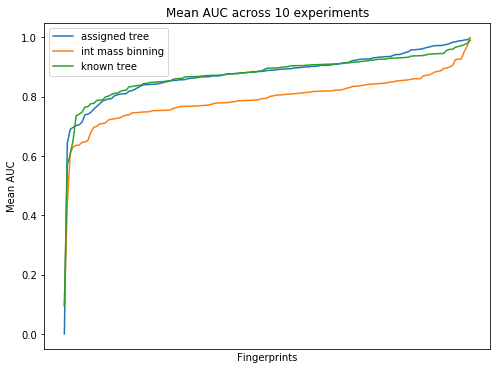

In [214]:
plt.title("Mean AUC across 10 experiments")
plt.plot(range(0, len(exp_mean_auc_scores)), exp_mean_auc_scores, label="assigned tree")
plt.plot(range(0, len(base_mean_auc_scores)), base_mean_auc_scores, label="int mass binning")
plt.plot(range(0, len(known_tree_mean_auc_scores)), known_tree_mean_auc_scores, label="known tree")
plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("Mean AUC")
plt.show()

AUC

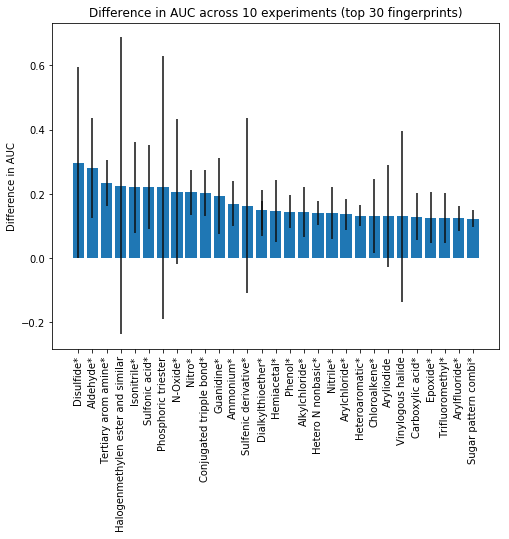

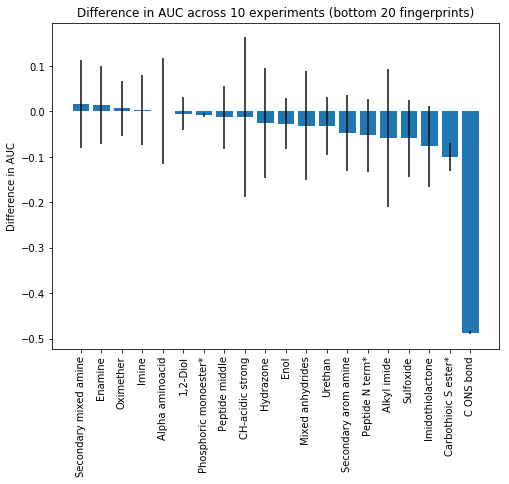

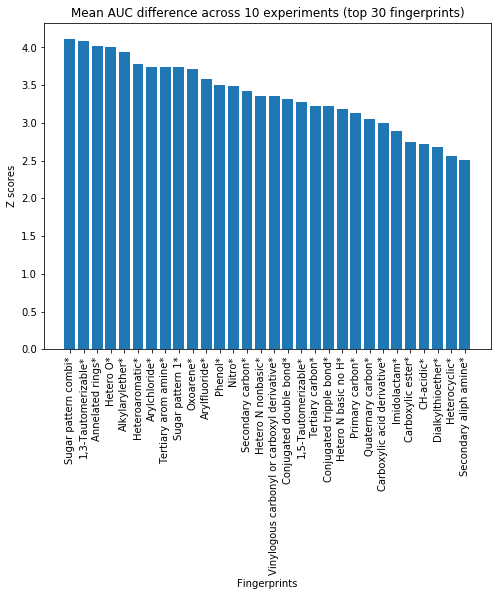

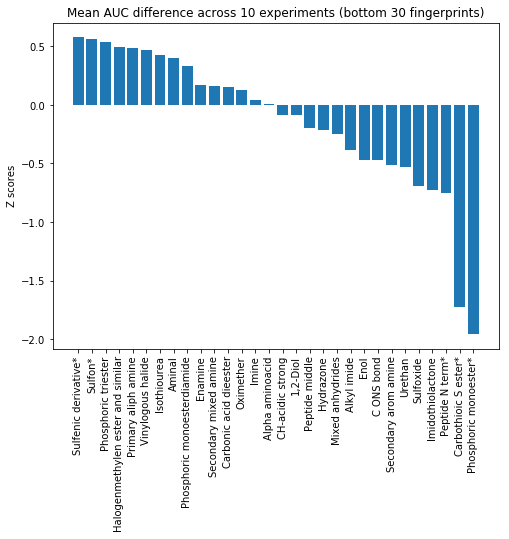

106 significantly different mean aucs
103 significantly positive difference
3 significantly negative difference


In [215]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)

plt.title("Difference in AUC across 10 experiments (top 30 fingerprints)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Difference in AUC across 10 experiments (bottom 20 fingerprints)")
plt.bar(fingerprints[119:], score_differences[119:], align='center', yerr=std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Mean AUC difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores")
plt.show()

plt.title("Mean AUC difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(z_fingerprints[109:], z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

F1

In [216]:
f1_differences = []
f1_z_differences = []
f1_pvalues = []

for i in assigned_known_ionization_tree_auc_df.columns:
    base_f1s = fragments_with_shifts_f1_df[i].tolist()
    base_mean = statistics.mean(base_f1s)
    base_std = statistics.stdev(base_f1s)
    
    exp_f1s = assigned_known_ionization_tree_f1_df[i].tolist()
    exp_mean = statistics.mean(exp_f1s)
    exp_std = statistics.stdev(exp_f1s)
    
    difference = [exp_f1-base_f1s[index] for index, exp_f1 in enumerate(exp_f1s) if exp_f1-base_f1s[index] != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    f1_pvalues.append((i, t_test.pvalue))

In [217]:
f1_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

f1_differences.reverse()
f1_z_differences.reverse()

In [218]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [219]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]

f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

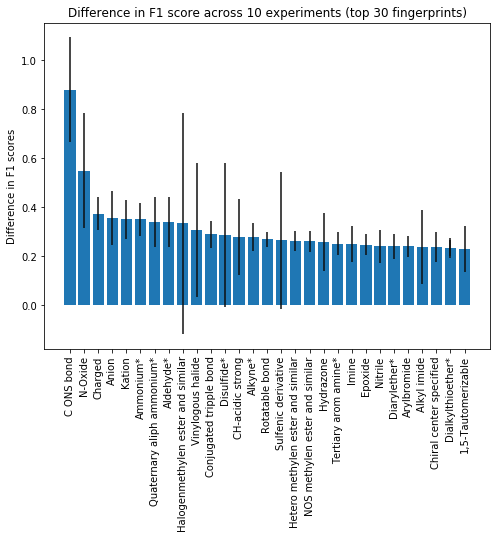

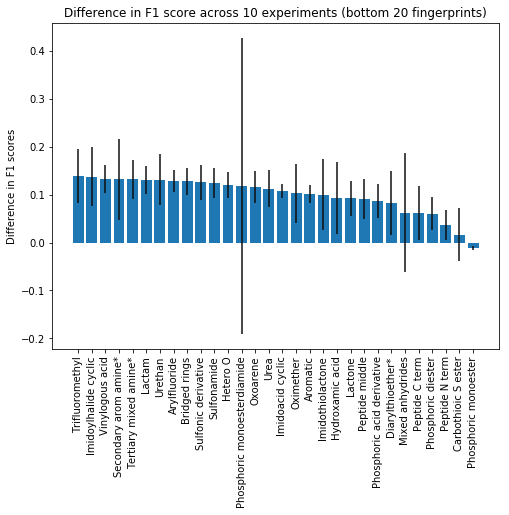

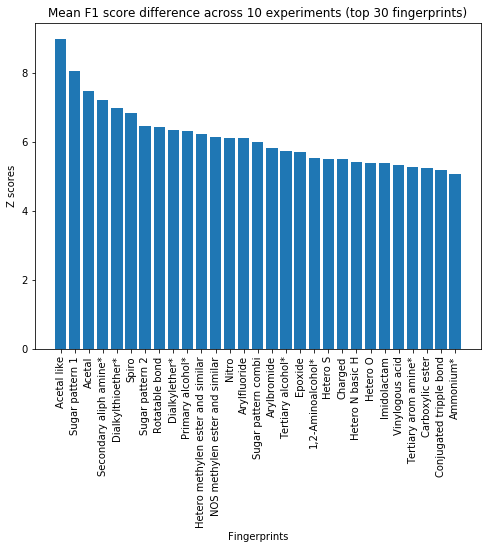

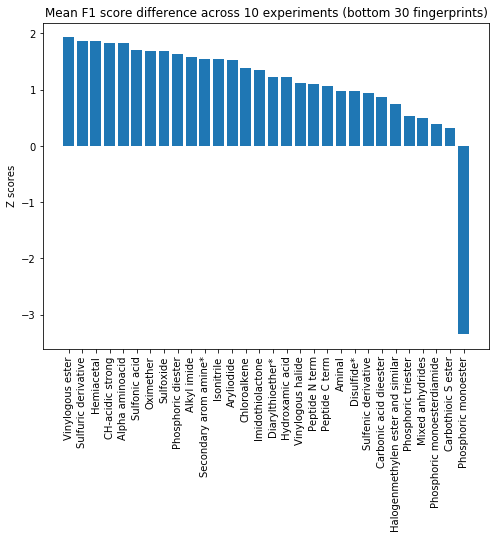

35 significantly different mean f1 scores
35 significantly positive difference
0 significantly negative difference


In [220]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (top 30 fingerprints)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Difference in F1 score across 10 experiments (bottom 20 fingerprints)")
plt.bar(f1_fingerprints[109:], f1_score_differences[109:], align='center', yerr=f1_std_err[109:], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Mean F1 score difference across 10 experiments (top 30 fingerprints)")
plt.bar(f1_z_fingerprints[:30], f1_z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores")
plt.show()

plt.title("Mean F1 score difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(f1_z_fingerprints[109:], f1_z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1 scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

Compare with known tree

In [221]:
differences = []
z_differences = []
pvalues = []
base_mean_aucs = []
exp_mean_aucs = []

for i in assigned_known_ionization_tree_auc_df.columns:
    base_aucs = known_tree_auc_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = assigned_known_ionization_tree_auc_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    base_mean_aucs.append(base_mean)
    exp_mean_aucs.append(exp_mean)
    difference = [exp_auc-base_aucs[index] for index, exp_auc in enumerate(exp_aucs) if exp_auc-base_aucs[index] != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    pvalues.append((i, t_test.pvalue))

In [222]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))
base_mean_aucs.sort()
exp_mean_aucs.sort()

differences.reverse()
z_differences.reverse()

In [223]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [224]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]

z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]

score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

Trend comparison

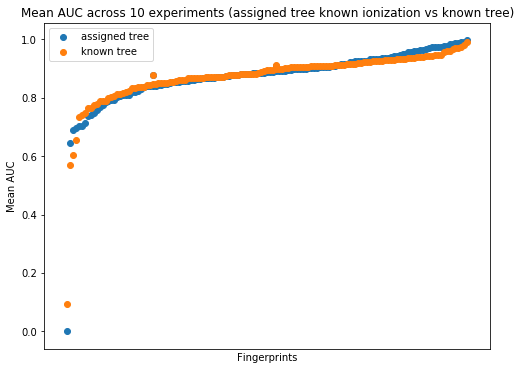

In [225]:
plt.title("Mean AUC across 10 experiments (assigned tree known ionization vs known tree)")
plt.scatter(fingerprints, exp_mean_aucs, label="assigned tree")
plt.scatter(fingerprints, base_mean_aucs, label="known tree")
plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("Mean AUC")
plt.show()

AUC

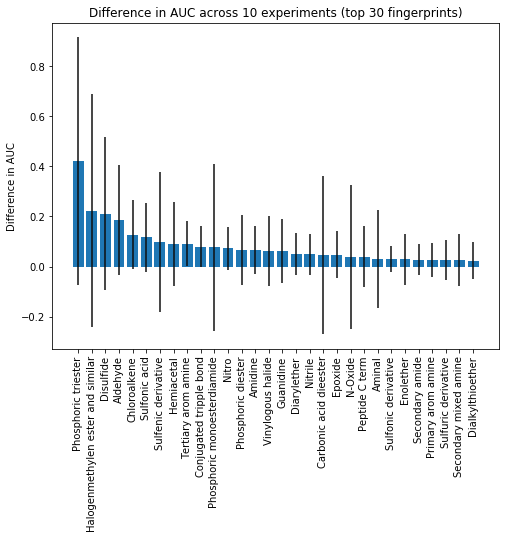

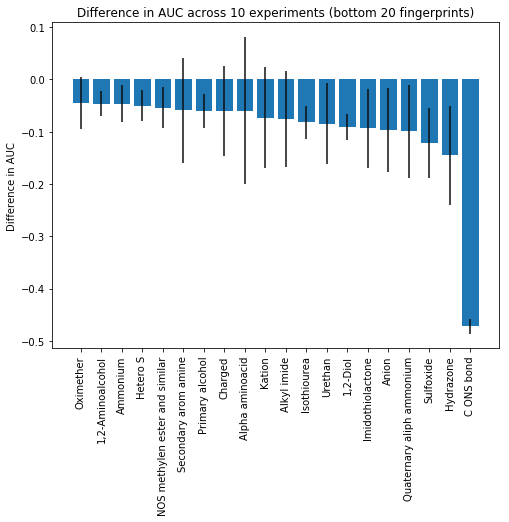

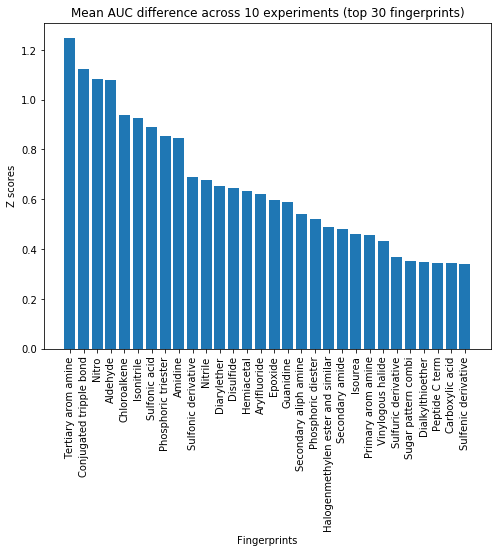

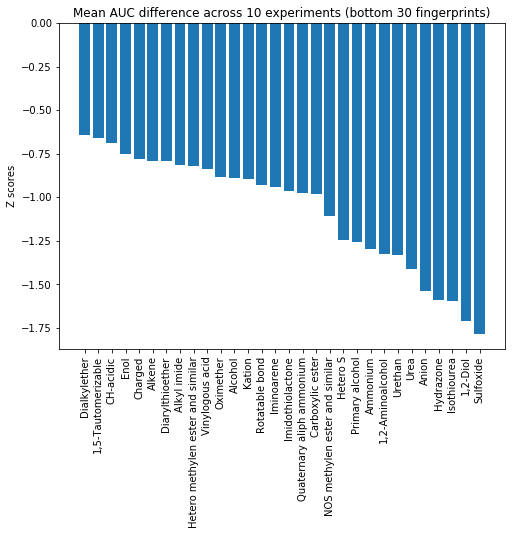

0 significantly different mean aucs
0 significantly positive difference
0 significantly negative difference


In [226]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)

plt.title("Difference in AUC across 10 experiments (top 30 fingerprints)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Difference in AUC across 10 experiments (bottom 20 fingerprints)")
plt.bar(fingerprints[119:], score_differences[119:], align='center', yerr=std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Mean AUC difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores")
plt.show()

plt.title("Mean AUC difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(z_fingerprints[109:], z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))